# Constants

In [1]:
ROOT_PATH = "/kaggle/input"
DATA_PATH = "/kaggle/input/monusac-pannuke-consep"

In [2]:
DATASET = "CoNSeP_Tiled" # MoNuSAC, PanNuke, CoNSeP_Tiled
NUM_CLASSES = 8 # 5, 6, 8
BATCH_SIZE = 16

# Data Loading

In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (str): Root dataset directory, e.g., "MoNuSAC"
            split (str): One of 'train', 'val', 'test'
            image_transform (callable, optional): Transform applied only to image
        """
        self.split_dir = os.path.join(root_dir, split)
        self.sample_dirs = sorted([
            os.path.join(self.split_dir, d)
            for d in os.listdir(self.split_dir)
            if os.path.isdir(os.path.join(self.split_dir, d))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]

        image = np.load(os.path.join(sample_dir, "image.npy"))  # HWC
        mask = np.load(os.path.join(sample_dir, "mask.npy"))    # HW
        h_map = np.load(os.path.join(sample_dir, "h_map.npy"))  # HW
        v_map = np.load(os.path.join(sample_dir, "v_map.npy"))  # HW

        h_map = (h_map.astype(np.float32) / 127.5) - 1.0
        v_map = (v_map.astype(np.float32) / 127.5) - 1.0

        if self.transform:
            image = self.transform(image)

        return image, \
                torch.from_numpy(mask).long(), \
                torch.from_numpy(h_map).float(), \
                torch.from_numpy(v_map).float()

In [4]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts HWC to CHW and scales to [0, 1]
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # example: scale to [-1, 1]
])

dataset_path = os.path.join(DATA_PATH, DATASET)

train_dataset = SegmentationDataset(dataset_path, split="train", transform=transform)
val_dataset = SegmentationDataset(dataset_path, split="val", transform=transform)
test_dataset = SegmentationDataset(dataset_path, split="test", transform=transform)

In [5]:
from torch.utils.data import Dataset, DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [6]:
print("First fold:", len(train_dataloader))
print("Second fold:", len(val_dataloader))
print("Third fold:", len(test_dataloader))

First fold: 13
Second fold: 4
Third fold: 8


In [7]:
image, mask, h_map, v_map = next(iter(train_dataloader))
print(image.shape)
print(mask.shape)
print(h_map.shape)
print(v_map.shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 256, 256])
torch.Size([16, 256, 256])
torch.Size([16, 256, 256])


# Graph HoVerNet

In [8]:
!pip install -U segmentation-models-pytorch torch-geometric scikit-image

In [9]:
def get_sinusoidal_encoding(coords, num_freqs=64):
    """
    coords: (N, 2) integer tensor with (y, x) positions
    returns: (N, 4 * num_freqs) tensor of sinusoidal embeddings
    """
    device = coords.device
    N = coords.size(0)
    freqs = torch.arange(num_freqs, dtype=torch.float32, device=device)  # [0, 1, ..., num_freqs-1]
    freqs = 1.0 / (10000 ** (freqs / num_freqs))  # shape: [num_freqs]

    pos_y = coords[:, 0].unsqueeze(1).float()  # [N, 1]
    pos_x = coords[:, 1].unsqueeze(1).float()  # [N, 1]

    y_embed = pos_y * freqs  # [N, num_freqs]
    x_embed = pos_x * freqs

    sin_cos_y = torch.cat([y_embed.sin(), y_embed.cos()], dim=1)
    sin_cos_x = torch.cat([x_embed.sin(), x_embed.cos()], dim=1)
    return torch.cat([sin_cos_y, sin_cos_x], dim=1)  # [N, 4 * num_freqs]

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data, Batch
from sklearn.neighbors import NearestNeighbors
import numpy as np

from torch_geometric.nn import GENConv, LayerNorm, Linear


class GraphBranch(nn.Module):
    """Node-level GNN classifier using 3-layer GENConv with edge_attr"""
    def __init__(self, in_channels=512, hidden_channels=128, edge_dim=256, num_layers=3, num_classes=5, dropout=0.1):
        super().__init__()

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        self.convs.append(GENConv(in_channels, hidden_channels, edge_dim=edge_dim))
        self.norms.append(LayerNorm(hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(GENConv(hidden_channels, hidden_channels, edge_dim=edge_dim))
            self.norms.append(LayerNorm(hidden_channels))

        self.convs.append(GENConv(hidden_channels, hidden_channels, edge_dim=edge_dim))
        self.norms.append(LayerNorm(hidden_channels))

        self.classifier = nn.Sequential(
            Linear(hidden_channels, hidden_channels // 2),
            LayerNorm(hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            Linear(hidden_channels // 2, num_classes)
        )

        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr):
        x = self.convs[0](x, edge_index, edge_attr)
        x = self.norms[0](x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        for i in range(1, len(self.convs) - 1):
            residual = x
            x = self.convs[i](x, edge_index, edge_attr)
            x = self.norms[i](x)
            x = F.relu(x + residual)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.convs[-1](x, edge_index, edge_attr)
        x = self.norms[-1](x)
        x = F.relu(x)

        node_pred = self.classifier(x)
        return node_pred, x  # logits, final embeddings

class GraphHoverNet(nn.Module):
    def __init__(self, num_classes=6, encoder_name='resnet34', encoder_weights='imagenet', 
                 use_graph=True, k_neighbors=8, graph_feature_dim=288):
        super().__init__()
        self.use_graph = use_graph
        self.k_neighbors = k_neighbors

        # Shared encoder
        self.shared_encoder = smp.encoders.get_encoder(encoder_name, in_channels=3, depth=5, weights=encoder_weights)

        # Use shared encoder in all heads
        self.model_np = smp.Unet(encoder_name=encoder_name, encoder_weights=None,
                                         in_channels=3, classes=2, activation=None)
        self.model_hv = smp.Unet(encoder_name=encoder_name, encoder_weights=None,
                                         in_channels=3, classes=2, activation=None)
        self.model_nc = smp.Unet(encoder_name=encoder_name, encoder_weights=None,
                                         in_channels=3, classes=num_classes, activation=None)

        self.model_np.encoder = self.shared_encoder
        self.model_hv.encoder = self.shared_encoder
        self.model_nc.encoder = self.shared_encoder

        if self.use_graph:
            self.graph_branch = GraphBranch(in_channels=graph_feature_dim,
                                            num_layers=2, num_classes=num_classes)

    def set_stage(self, stage):
        if stage == 'pretrain':
            self.use_graph = False

            for m in [self.model_np, self.model_hv, self.model_nc]:
                    for p in m.parameters():
                        p.requires_grad = True

        elif stage == 'finetune':
            self.use_graph = True

            for p in self.shared_encoder.parameters():
                p.requires_grad = False

            # Unfreeze everything else
            for m in [self.model_np.decoder, self.model_np.segmentation_head,
                      self.model_hv.decoder, self.model_hv.segmentation_head,
                      self.model_nc.decoder, self.model_nc.segmentation_head,
                      self.graph_branch]:
                for p in m.parameters():
                    p.requires_grad = True
                    
    def extract_nucleus_centroids(self, np_pred, hv_pred, threshold=0.5):
        batch_size = np_pred.shape[0]
        centroids_list = []
        for b in range(batch_size):
            prob_map = torch.sigmoid(np_pred[b, 1])
            mask = prob_map > threshold
            if mask.sum() == 0:
                centroids_list.append(torch.empty(0, 2).to(np_pred.device))
                continue
            coords = torch.nonzero(mask, as_tuple=False).float()
            if coords.shape[0] > 500:
                probs = prob_map[mask]
                _, top_indices = torch.topk(probs, 500)
                coords = coords[top_indices]
            centroids_list.append(coords)
        return centroids_list

    def build_graph(self, centroids, features):
        if centroids.shape[0] == 0:
            return torch.empty(2, 0).long().to(centroids.device)
        centroids_np = centroids.cpu().numpy()
        if centroids_np.shape[0] <= self.k_neighbors:
            n = centroids_np.shape[0]
            edges = []
            for i in range(n):
                for j in range(i + 1, n):
                    edges.extend([[i, j], [j, i]])
            if len(edges) == 0:
                return torch.empty(2, 0).long().to(centroids.device)
            edge_index = torch.tensor(edges).t().contiguous().to(centroids.device)
        else:
            nbrs = NearestNeighbors(n_neighbors=min(self.k_neighbors + 1, centroids_np.shape[0]))
            nbrs.fit(centroids_np)
            distances, indices = nbrs.kneighbors(centroids_np)
            edges = []
            for i in range(indices.shape[0]):
                for j in range(1, indices.shape[1]):
                    edges.extend([[i, indices[i, j]], [indices[i, j], i]])
            edge_index = torch.tensor(edges).t().contiguous().to(centroids.device)
        return edge_index

    def forward(self, x):
        batch_size = x.shape[0]
        out_np = self.model_np(x)
        out_hv = self.model_hv(x)
        out_nc = self.model_nc(x)
        if not self.use_graph:
            return out_np, out_hv, out_nc, None, None

        out_gc = None
        graph_enhanced_nc = out_nc.clone()
        encoder_feats = self.shared_encoder(x)
        encoder_features = F.interpolate(encoder_feats[-2], size=(255, 255), mode="bilinear", align_corners=False)

        all_centroids = []
        all_out_gc = []
        
        for b in range(batch_size):
            centroids = self.extract_nucleus_centroids(out_np[b:b+1], out_hv[b:b+1], threshold=0.3)[0]
            if centroids.shape[0] == 0:
                continue
            h, w = encoder_features.shape[2], encoder_features.shape[3]
            centroid_coords = centroids.long()
            centroid_coords[:, 0] = torch.clamp(centroid_coords[:, 0], 0, h - 1)
            centroid_coords[:, 1] = torch.clamp(centroid_coords[:, 1], 0, w - 1)
            node_feats = encoder_features[b, :, centroid_coords[:, 0], centroid_coords[:, 1]].t()
            
            # Generate sinusoidal positional encodings
            pos_enc = get_sinusoidal_encoding(centroid_coords, num_freqs=8)  # [N, 32]
            
            # Concatenate encoder + positional features
            node_features = torch.cat([node_feats, pos_enc], dim=1)  # [N, C + 32]

            edge_index = self.build_graph(centroids, node_features)

            mid = ((centroid_coords[edge_index[0]] + centroid_coords[edge_index[1]]) / 2).long()
            mid[:, 0] = mid[:, 0].clamp(0, 254)
            mid[:, 1] = mid[:, 1].clamp(0, 254)
            
            # Edge attributes from midpoints
            edge_attr = encoder_features[b][:, mid[:, 0], mid[:, 1]].t()  # [num_edges, C]
            if edge_index.shape[1] > 0:
                out_gc, _ = self.graph_branch(node_features, edge_index, edge_attr)
                all_centroids.append(torch.cat([centroid_coords, torch.full((centroid_coords.shape[0], 1), b, device=x.device)], dim=1))  # (N, 3): (y, x, batch_id)
                all_out_gc.append(out_gc)

        if all_centroids:
            centroid_coords = torch.cat(all_centroids, dim=0)  # (sum(N), 3)
            out_gc = torch.cat(all_out_gc, dim=0)              # (sum(N), C)
        else:
            centroid_coords = torch.empty(0, 3, device=x.device)
            out_gc = None

        return out_np, out_hv, out_nc, centroid_coords, out_gc

    def print_model_stats(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    
        def count_params(module):
            return sum(p.numel() for p in module.parameters())
    
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Shared encoder parameters: {count_params(self.shared_encoder):,}")
        print(f"NP head parameters (excluding encoder): {count_params(self.model_np.decoder) + count_params(self.model_np.segmentation_head):,}")
        print(f"HV head parameters (excluding encoder): {count_params(self.model_hv.decoder) + count_params(self.model_hv.segmentation_head):,}")
        print(f"NC head parameters (excluding encoder): {count_params(self.model_nc.decoder) + count_params(self.model_nc.segmentation_head):,}")
        print(f"Graph branch parameters: {count_params(self.graph_branch):,}")

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class DiceCoeff(nn.Module):
    def __init__(self, ignore_index: int = None, smooth: float = 1e-7):
        super().__init__()
        self.ignore_index = ignore_index
        self.smooth = smooth

    def forward(self, inputs, targets):
        """
        inputs: (N, C, ...) — raw logits
        targets: (N, ...) — class indices
        """
        inputs = F.softmax(inputs, dim=1)  # Convert to probabilities
        N, C = inputs.shape[:2]
        spatial_dims = inputs.shape[2:]  # Arbitrary spatial shape

        # One-hot encode targets to (N, C, ...)
        targets_onehot = F.one_hot(targets, num_classes=C).permute(0, -1, *range(1, targets.ndim)).float()

        # Flatten all dimensions except batch and channel
        inputs_flat = inputs.view(N, C, -1)
        targets_flat = targets_onehot.view(N, C, -1)

        # Optional: handle ignore index
        if self.ignore_index is not None:
            mask = targets != self.ignore_index  # shape (N, ...)
            mask = mask.view(N, -1).unsqueeze(1)  # (N, 1, num_voxels)
            inputs_flat = inputs_flat * mask
            targets_flat = targets_flat * mask

        intersection = (inputs_flat * targets_flat).sum(dim=2)
        dice = (2. * intersection + self.smooth) / (
            inputs_flat.sum(dim=2) + targets_flat.sum(dim=2) + self.smooth
        )
        return 1 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', ignore_index=-100):
        """
        Multi-class focal loss implementation.
        Args:
            alpha (float): balancing factor for classes.
            gamma (float): focusing parameter.
            reduction (str): 'mean', 'sum' or 'none'.
            ignore_index (int, optional): class index to ignore in loss.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none', ignore_index=self.ignore_index)
        pt = torch.exp(-ce_loss)  # pt = softmax prob of the correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
            
class LaplacianLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Define a 3x3 Laplacian kernel
        kernel = torch.tensor([[0, 1, 0],
                               [1, -4, 1],
                               [0, 1, 0]], dtype=torch.float32).view(1, 1, 3, 3)
        self.register_buffer('kernel', kernel)

    def forward(self, pred: torch.Tensor):
        """
        Args:
            pred: (N, 1, H, W) tensor on any device
        Returns:
            Laplacian smoothness loss (scalar)
        """
        # Move kernel to the same device as pred
        if pred.dim() == 3:
            pred = pred.unsqueeze(1)
        kernel = self.kernel.to(pred.device)
        pred_lap = F.conv2d(pred, kernel, padding=1)
        return torch.mean(torch.abs(pred_lap))

class _NPBranchLoss(nn.Module):
    def __init__(self, alpha=1, beta=1):
        super(_NPBranchLoss, self).__init__()
        self.dice_coeff = DiceCoeff()
        self.alpha = alpha
        self.beta = beta

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(logits, targets)
        dice_loss = 1 - self.dice_coeff(logits, targets)
        return self.alpha * ce_loss + self.beta * dice_loss


class _HVBranchLoss(nn.Module):
    def __init__(self, alpha=1, beta=1):
        super().__init__()
        self.laplacian = LaplacianLoss()
        self.alpha = alpha
        self.beta = beta

    def forward(self, logits: torch.Tensor, h_grads: torch.Tensor, v_grads: torch.Tensor):
        hl = logits[:, 0, :, :]
        vl = logits[:, 1, :, :]

        mse_loss = F.mse_loss(hl, h_grads) + F.mse_loss(vl, v_grads)
        laplacian_loss = self.laplacian(hl) + self.laplacian(vl)

        return self.alpha * mse_loss + self.beta * laplacian_loss

class _GCBranchLoss(nn.Module):
    def __init__(self, alpha=1, beta=1, gamma=1):
        super(_GCBranchLoss, self).__init__()
        self.dice_coeff = DiceCoeff()
        self.focal_loss = FocalLoss()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(logits, targets)
        dice_loss = 1 - self.dice_coeff(logits, targets)
        focal_loss = self.focal_loss(logits, targets)
        return self.alpha * ce_loss + self.beta * dice_loss + self.gamma * focal_loss
        
class HoverLoss(nn.Module):
    def __init__(self):
        super(HoverLoss, self).__init__()
        self.np_loss = _NPBranchLoss(0.75, 0.25)
        self.hv_loss = _HVBranchLoss(0.5, 0.5)
        self.nc_loss = _NPBranchLoss(0.75, 0.25)
        self.gc_loss = _GCBranchLoss(1, 1, 1)

    def forward(self, np_logits, np_targets,
                hv_logits, h_grads, v_grads,
                nc_logits, nc_targets,
                gc_logits=None, gc_targets=None,
                weights=(1, 1, 1, 1)) -> torch.Tensor:

        loss_np = self.np_loss(np_logits, np_targets) * weights[0]
        loss_hv = self.hv_loss(hv_logits, h_grads, v_grads) * weights[1]
        loss_nc = self.nc_loss(nc_logits, nc_targets) * weights[2]

        if gc_logits is not None and gc_targets is not None and gc_logits.numel() > 0:
            loss_gc = self.gc_loss(gc_logits, gc_targets) * weights[3]
        else:
            loss_gc = torch.tensor(0.0, device=np_logits.device)

        return loss_np + loss_hv + loss_nc + loss_gc

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphHoverNet(num_classes=NUM_CLASSES)
model = model.to(device)
criterion = HoverLoss()

In [13]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [14]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

def postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device, return_centroids=False, nr_types=6):
    """
    Postprocess HoVerNet outputs to obtain instance segmentation and class predictions.

    Args:
        np_logits (Tensor): [B, 1, H, W] - nuclei presence logits.
        hv_logits (Tensor): [B, 2, H, W] - horizontal and vertical offset logits.
        nc_logits (Tensor): [B, C, H, W] - nuclear classification logits.
        device (torch.device): Device for output tensors.
        return_centroids (bool): Placeholder for future use.
        nr_types (int): Number of nuclear classes.

    Returns:
        Tensor: [B, H, W] instance segmentation with class IDs.
    """
    def process(pred_map: torch.Tensor) -> torch.Tensor:
        """
        Process a single HoVerNet prediction map to obtain instance-wise segmentation with class labels.

        Args:
            pred_map (Tensor): [H, W, 4] - np_mask, h_map, v_map, class_map

        Returns:
            Tensor: [H, W] with instance-wise majority-vote class labels.
        """
        pred_map = pred_map.cpu().numpy()
        np_mask = pred_map[:, :, 0] > 0.5
        h_map = pred_map[:, :, 1]
        v_map = pred_map[:, :, 2]
        class_map = pred_map[:, :, 3].astype(np.int32)

        # --- Energy landscape: gradient magnitude ---
        dx = cv2.Sobel(h_map, cv2.CV_64F, 1, 0, ksize=3)
        dy = cv2.Sobel(v_map, cv2.CV_64F, 0, 1, ksize=3)
        energy = np.sqrt(dx ** 2 + dy ** 2)

        energy = (energy - energy.min()) / (energy.max() - energy.min() + 1e-8)
        energy = 1.0 - energy  # Nuclei centers become minima

        # --- Marker-based watershed ---
        distance = ndi.distance_transform_edt(np_mask)
        coords = peak_local_max(distance, labels=np_mask, footprint=np.ones((3, 3)), exclude_border=False)
        markers = np.zeros_like(np_mask, dtype=np.int32)
        for idx, (y, x) in enumerate(coords, start=1):
            markers[y, x] = idx

        instance_map = watershed(energy, markers=markers, mask=np_mask)

        # --- Majority vote for class per instance ---
        type_map = np.zeros_like(instance_map, dtype=np.int32)
        for inst_id in range(1, instance_map.max() + 1):
            mask = instance_map == inst_id
            class_ids, counts = np.unique(class_map[mask], return_counts=True)
            if len(class_ids) > 0:
                majority_class = class_ids[np.argmax(counts)]
                type_map[mask] = majority_class

        return torch.from_numpy(type_map).long().to(device)

    # --- Batch processing ---
    batch_size = np_logits.shape[0]
    np_pred = torch.argmax(np_logits, dim=1, keepdim=True)  # [B, 1, H, W]
    nc_pred = torch.argmax(nc_logits, dim=1, keepdim=True)  # [B, 1, H, W]

    results = []
    for i in range(batch_size):
        nuclei_presence = np_pred[i].permute(1, 2, 0)           # [H, W, 1]
        h_map = hv_logits[i, 0:1].permute(1, 2, 0)              # [H, W, 1]
        v_map = hv_logits[i, 1:2].permute(1, 2, 0)              # [H, W, 1]
        class_map = nc_pred[i].permute(1, 2, 0) if nr_types else torch.zeros_like(h_map)

        pred_map = torch.cat([nuclei_presence, h_map, v_map, class_map], dim=-1)  # [H, W, 4]
        instance_seg = process(pred_map)  # [H, W]
        results.append(instance_seg)

    return torch.stack(results)  # [B, H, W]

In [15]:
def get_node_labels_from_coords(centroid_coords, type_maps):
    """
    Args:
        centroid_coords: (N, 3) tensor, (y, x, batch_id)
        type_maps: (B, H, W) tensor of type labels

    Returns:
        labels: (N,) long tensor
    """
    y = centroid_coords[:, 0].clamp(0, type_maps.shape[1] - 1)
    x = centroid_coords[:, 1].clamp(0, type_maps.shape[2] - 1)
    b = centroid_coords[:, 2].clamp(0, type_maps.shape[0] - 1)

    return type_maps[b, y, x]

In [16]:
model.set_stage("pretrain")

with torch.no_grad():
    images, masks, h_grads, v_grads = next(iter(train_dataloader))
    images = images.to(device)
    masks = masks.to(device).long()
    h_grads = h_grads.to(device)
    v_grads = v_grads.to(device)

    nc_targets = masks
    np_targets = (nc_targets > 0).long()

    np_logits, hv_logits, nc_logits, centroids, gc_logits = model(images)

    if gc_logits is not None and centroids.shape[0] > 0:
        node_labels = get_node_labels_from_coords(centroids, nc_targets)
        valid = node_labels != 0
    
        if valid.any():
            graph_loss_inputs = (gc_logits[valid], node_labels[valid])
        else:
            # No valid labels — skip graph loss
            graph_loss_inputs = (None, None)
    else:
        # No graph predictions — skip graph loss
        graph_loss_inputs = (None, None)
    
    loss = criterion(
        np_logits, np_targets,
        hv_logits, h_grads, v_grads,
        nc_logits, nc_targets,
        *graph_loss_inputs
    )
    
    # # Evaluate
    nc_pred = torch.argmax(nc_logits, dim=1)
    # iou = compute_multiclass_iou(pred_inst, nc_targets, num_classes=6)
    # pq = compute_multiclass_pq(pred_inst, nc_targets, num_classes=6)

    # Postprocess
    postprocessed_pred = postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device)

    tp, fp, fn, tn = smp.metrics.get_stats(
        postprocessed_pred, nc_targets,
        mode='multiclass',
        num_classes=NUM_CLASSES
    )

    iou_per_class = smp.metrics.iou_score(tp, fp, fn, tn, reduction='none').mean(dim=0)[1:]
    f1_per_class = smp.metrics.f1_score(tp, fp, fn, tn, reduction='none').mean(dim=0)[1:]
    pq_per_class = 2 * iou_per_class * f1_per_class / (iou_per_class + f1_per_class + 1e-8)
    
    print("Loss:", loss)
    print("AJI:", iou_per_class.mean())
    print("PQ:", pq_per_class.mean())
    print("Average F1:", f1_per_class.mean())
    print("F1 Per Class:", f1_per_class)

Loss: tensor(4.2946, device='cuda:0')
AJI: tensor(0.0075)
PQ: tensor(0.0098)
Average F1: tensor(0.0143)
F1 Per Class: tensor([0.0089, 0.0152, 0.0026, 0.0384, 0.0248, 0.0102, 0.0000])


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from skimage.color import label2rgb

def visualize_hovernet_output(pred_inst, inst_info=None, show_types=True):
    """
    Visualize the instance segmentation map with optional type labels and centroids.

    Args:
        pred_inst (np.ndarray): [H, W] array of instance IDs.
        inst_info (dict): {inst_id: {'centroid': (x, y), 'type': int}}, optional.
        show_types (bool): If True, display type labels at centroid positions.
    """

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(pred_inst, cmap="jet")
    ax.set_title("Instance Segmentation")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

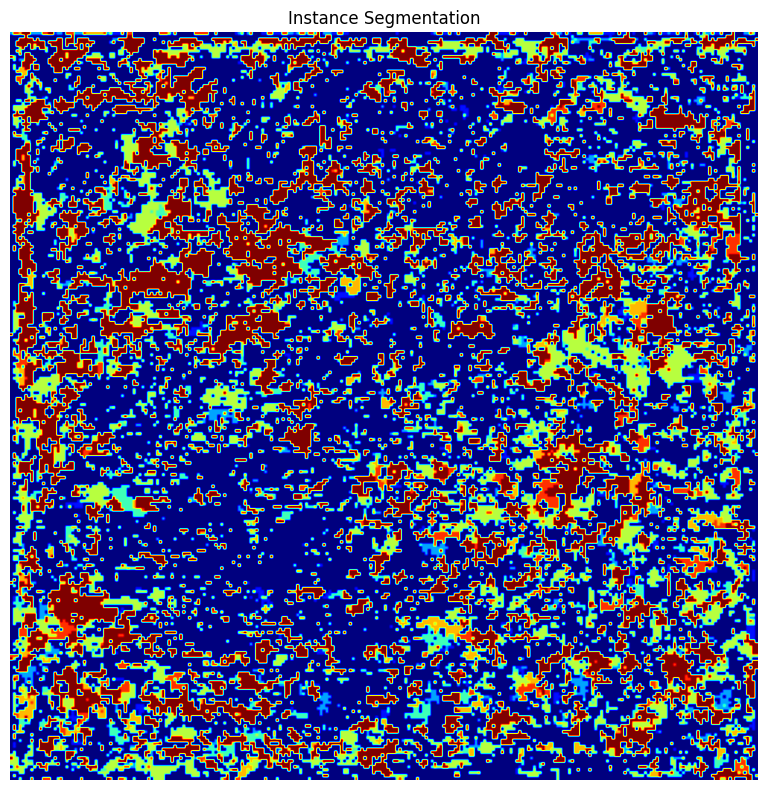

In [18]:
visualize_hovernet_output(postprocessed_pred.cpu().numpy()[0])

In [19]:
from tqdm import tqdm
import torch
from torch.amp import GradScaler, autocast
import segmentation_models_pytorch as smp

def train_one_epoch(model, dataloader, optimizer, criterion, device, num_classes=5):
    model.train()
    scaler = GradScaler()

    total_loss = 0.0
    total_iou = 0.0
    total_f1 = 0.0
    total_pq = 0.0
    total_f1_per_class = torch.zeros(num_classes, dtype=torch.float32, device=device)
    count = 0

    loop = tqdm(dataloader, desc="Training", leave=True)
    for image, mask, h_grads, v_grads in loop:
        image = image.to(device)
        mask = mask.to(device).long()
        h_grads = h_grads.to(device)
        v_grads = v_grads.to(device)

        nc_targets = mask
        np_targets = (mask > 0).long()

        optimizer.zero_grad()

        with autocast(device.type):
            np_logits, hv_logits, nc_logits, centroids, gc_logits = model(image)

            # Get graph branch labels
            if gc_logits is not None and centroids.shape[0] > 0:
                gc_targets = get_node_labels_from_coords(centroids, nc_targets)
                valid = gc_targets != 0
                if valid.any():
                    gc_input = (gc_logits[valid], gc_targets[valid])
                else:
                    gc_input = (None, None)
            else:
                gc_input = (None, None)

            # Compute total loss
            loss = criterion(
                np_logits, np_targets,
                hv_logits, h_grads, v_grads,
                nc_logits, nc_targets,
                *gc_input
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            nc_pred = torch.argmax(nc_logits, dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(
                nc_pred, nc_targets,
                mode='multiclass',
                num_classes=num_classes  # assuming class 0 is background
            )

            iou_per_class = smp.metrics.iou_score(tp, fp, fn, tn, reduction='none').mean(dim=0)
            f1_per_class = smp.metrics.f1_score(tp, fp, fn, tn, reduction='none').mean(dim=0)
            pq_per_class = 2 * iou_per_class * f1_per_class / (iou_per_class + f1_per_class + 1e-8)

        total_loss += loss.item()
        total_iou += iou_per_class[1:].mean().item()
        total_f1 += f1_per_class[1:].mean().item()
        total_pq += pq_per_class[1:].mean().item()
        total_f1_per_class += f1_per_class.to(device)  # accumulate per class
        count += 1

        loop.set_postfix(
            loss=total_loss / count,
            iou=total_iou / count,
            f1=total_f1 / count,
            pq=total_pq / count,
            f1_per_class=[round(x.item() / count, 4) for x in f1_per_class][1:]
        )

    return (
        total_loss / count,
        total_iou / count,
        total_f1 / count,
        total_pq / count,
        (total_f1_per_class / count).tolist()
    )


In [20]:
@torch.no_grad()
def validate(model, dataloader, criterion, device, num_classes=5, post_process=False):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_f1 = 0.0
    total_pq = 0.0
    total_f1_per_class = torch.zeros(num_classes, dtype=torch.float32, device=device)
    count = 0

    loop = tqdm(dataloader, desc="Validation", leave=True)
    for image, mask, h_grads, v_grads in loop:
        image = image.to(device)
        mask = mask.to(device).long()
        h_grads = h_grads.to(device)
        v_grads = v_grads.to(device)

        nc_targets = mask
        np_targets = (mask > 0).long()

        np_logits, hv_logits, nc_logits, centroids, gc_logits = model(image)

        # Process graph branch if available
        if gc_logits is not None and centroids.shape[0] > 0:
            gc_targets = get_node_labels_from_coords(centroids, nc_targets)
            valid = gc_targets != 0
            if valid.any():
                gc_input = (gc_logits[valid], gc_targets[valid])
            else:
                gc_input = (None, None)
        else:
            gc_input = (None, None)

        # Compute total loss
        loss = criterion(
            np_logits, np_targets,
            hv_logits, h_grads, v_grads,
            nc_logits, nc_targets,
            *gc_input
        )

        if post_process:
            nc_pred = postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device)
        else:
            nc_pred = torch.argmax(nc_logits, dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(
            nc_pred, nc_targets,
            mode='multiclass',
            num_classes=num_classes   # if class 0 is background
        )

        iou_per_class = smp.metrics.iou_score(tp, fp, fn, tn, reduction='none').mean(dim=0)  # [1:] to skip background
        f1_per_class = smp.metrics.f1_score(tp, fp, fn, tn, reduction='none').mean(dim=0)
        pq_per_class = 2 * iou_per_class * f1_per_class / (iou_per_class + f1_per_class + 1e-8)

        total_loss += loss.item()
        total_iou += iou_per_class[1:].mean().item()
        total_f1 += f1_per_class[1:].mean().item()
        total_pq += pq_per_class[1:].mean().item()
        total_f1_per_class += f1_per_class.to(device)  # accumulate
        count += 1

        loop.set_postfix(
            loss=total_loss / count,
            iou=total_iou / count,
            f1=total_f1 / count,
            pq=total_pq / count,
            f1_per_class=[round(x.item() / count, 4) for x in f1_per_class][1:]
        )

    return (
        total_loss / count,
        total_iou / count,
        total_f1 / count,
        total_pq / count,
        (total_f1_per_class / count).tolist()
    )


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.amp import GradScaler, autocast

def train(model, criterion, train_loader, val_loader, device, 
          epochs=20, lr=1e-4, num_classes=5, patience=5):
    
    def train_loop(stage_name, use_graph, start_epoch=1, lr=lr):
        nonlocal best_val_pq
        nonlocal epochs_no_improve

        best_val_pq = -float('inf')
        epochs_no_improve = 0
        
        print(f"\n=== Starting {stage_name} phase ===")
        model.set_stage('pretrain' if not use_graph else 'finetune')

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            current_epoch = start_epoch + epoch
            print(f"\nEpoch {current_epoch}/{start_epoch + epochs - 1} [{stage_name}]")
            
            train_loss, train_iou, train_f1, train_pq, train_f1_per_class = train_one_epoch(
                model, train_loader, optimizer, criterion, device, num_classes)
            val_loss, val_iou, val_f1, val_pq, val_f1_per_class = validate(
                model, val_loader, criterion, device, num_classes)

            # Store metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_ious.append(train_iou)
            val_ious.append(val_iou)
            train_f1s.append(train_f1)
            val_f1s.append(val_f1)
            train_pqs.append(train_pq)
            val_pqs.append(val_pq)
    
            print(f"Train Loss: {train_loss:.4f} | IoU: {train_iou:.4f} | F1: {train_f1:.4f} | PQ: {train_pq:.4f}")
            print(f"Val   Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f} | PQ: {val_pq:.4f}")
            
            # Print per-class F1 (excluding background class 0)
            train_f1_str = " | ".join(f"Class {i+1}: {x:.4f}" for i, x in enumerate(train_f1_per_class[1:]))
            val_f1_str = " | ".join(f"Class {i+1}: {x:.4f}" for i, x in enumerate(val_f1_per_class[1:]))
            print(f"Train F1 per class: {train_f1_str}")
            print(f"Val   F1 per class: {val_f1_str}")
    
            if val_pq > best_val_pq:
                best_val_pq = val_pq
                epochs_no_improve = 0
                torch.save(model.state_dict(), f"best_hovernet_{stage_name}.pt")
                print("Saved best model (based on PQ).")
            else:
                epochs_no_improve += 1
                print(f"No improvement in PQ for {epochs_no_improve} epoch(s).")
    
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs with no improvement in PQ.")
                break
        
        return current_epoch + 1

    # Track metrics
    train_losses, val_losses = [], []
    train_ious, val_ious = [], []
    train_f1s, val_f1s = [], []
    train_pqs, val_pqs = [], []

    best_val_pq = -float('inf')
    epochs_no_improve = 0

    next_epoch = train_loop(stage_name='pretrain', use_graph=False, start_epoch=1)
    next_epoch = train_loop(stage_name='finetune', use_graph=True, start_epoch=next_epoch, lr=1e-2)

    print(f"\nTraining complete. Best Val PQ: {best_val_pq:.4f}")

    # === Plotting ===
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs_range, train_ious, label='Train IoU')
    plt.plot(epochs_range, val_ious, label='Val IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('IoU over Epochs')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(epochs_range, train_f1s, label='Train F1')
    plt.plot(epochs_range, val_f1s, label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 over Epochs')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs_range, train_pqs, label='Train PQ')
    plt.plot(epochs_range, val_pqs, label='Val PQ')
    plt.xlabel('Epoch')
    plt.ylabel('PQ')
    plt.title('PQ over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # === Save metrics ===
    metrics_df = pd.DataFrame({
        "Epoch": list(epochs_range),
        "Train Loss": train_losses,
        "Val Loss": val_losses,
        "Train IoU": train_ious,
        "Val IoU": val_ious,
        "Train F1": train_f1s,
        "Val F1": val_f1s,
        "Train PQ": train_pqs,
        "Val PQ": val_pqs,
    })
    metrics_df.to_csv("training_metrics.csv", index=False)
    print("Saved training metrics to training_metrics.csv")

In [22]:
@torch.no_grad()
def final_evaluate(model, test_loader, criterion, device, stage_name, num_classes=6):
    model.load_state_dict(torch.load(f"best_hovernet_{stage_name}.pt"))
    model.set_stage(stage_name)
    
    test_loss, test_iou, test_f1, test_pq, f1_per_class = validate(
        model, test_loader, criterion, device, num_classes, post_process=True
    )
    
    print(f"\nFinal Test | Loss: {test_loss:.4f} | IoU: {test_iou:.4f} | F1: {test_f1:.4f} | PQ: {test_pq:.4f}")
    print("F1 per class (excluding background):", f1_per_class)

In [23]:
import gc

gc.collect()
torch.cuda.empty_cache()


=== Starting pretrain phase ===

Epoch 1/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s, f1=0.0304, f1_per_class=[0.0008, 0.0, 0.0, 0.0553, 0.0208, 0.0, 0.0], iou=0.0167, loss=12.4, pq=0.0215]           


Train Loss: 3.7146 | IoU: 0.0129 | F1: 0.0239 | PQ: 0.0167
Val   Loss: 12.3647 | IoU: 0.0167 | F1: 0.0304 | PQ: 0.0215
Train F1 per class: Class 1: 0.0051 | Class 2: 0.0327 | Class 3: 0.0090 | Class 4: 0.0664 | Class 5: 0.0352 | Class 6: 0.0181 | Class 7: 0.0006
Val   F1 per class: Class 1: 0.0048 | Class 2: 0.0155 | Class 3: 0.0167 | Class 4: 0.1066 | Class 5: 0.0559 | Class 6: 0.0130 | Class 7: 0.0002
Saved best model (based on PQ).

Epoch 2/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, f1=0.0283, f1_per_class=[0.0109, 0.0011, 0.0, 0.0417, 0.0126, 0.0, 0.0], iou=0.0152, loss=3.83, pq=0.0198]         


Train Loss: 2.5179 | IoU: 0.0146 | F1: 0.0265 | PQ: 0.0188
Val   Loss: 3.8327 | IoU: 0.0152 | F1: 0.0283 | PQ: 0.0198
Train F1 per class: Class 1: 0.0057 | Class 2: 0.0578 | Class 3: 0.0046 | Class 4: 0.0724 | Class 5: 0.0271 | Class 6: 0.0173 | Class 7: 0.0006
Val   F1 per class: Class 1: 0.0129 | Class 2: 0.0430 | Class 3: 0.0030 | Class 4: 0.0839 | Class 5: 0.0396 | Class 6: 0.0156 | Class 7: 0.0001
No improvement in PQ for 1 epoch(s).

Epoch 3/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, f1=0.0298, f1_per_class=[0.0014, 0.0017, 0.0, 0.0523, 0.0067, 0.0, 0.0], iou=0.0165, loss=2.23, pq=0.0212]      


Train Loss: 1.9952 | IoU: 0.0161 | F1: 0.0286 | PQ: 0.0205
Val   Loss: 2.2329 | IoU: 0.0165 | F1: 0.0298 | PQ: 0.0212
Train F1 per class: Class 1: 0.0063 | Class 2: 0.0679 | Class 3: 0.0026 | Class 4: 0.0754 | Class 5: 0.0240 | Class 6: 0.0228 | Class 7: 0.0011
Val   F1 per class: Class 1: 0.0030 | Class 2: 0.0544 | Class 3: 0.0018 | Class 4: 0.1038 | Class 5: 0.0230 | Class 6: 0.0227 | Class 7: 0.0000
No improvement in PQ for 2 epoch(s).

Epoch 4/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, f1=0.0424, f1_per_class=[0.0, 0.0027, 0.0, 0.0841, 0.0041, 0.0, 0.0], iou=0.0259, loss=1.91, pq=0.032]            


Train Loss: 1.7682 | IoU: 0.0188 | F1: 0.0324 | PQ: 0.0238
Val   Loss: 1.9135 | IoU: 0.0259 | F1: 0.0424 | PQ: 0.0320
Train F1 per class: Class 1: 0.0069 | Class 2: 0.0850 | Class 3: 0.0012 | Class 4: 0.0915 | Class 5: 0.0130 | Class 6: 0.0270 | Class 7: 0.0023
Val   F1 per class: Class 1: 0.0167 | Class 2: 0.0730 | Class 3: 0.0008 | Class 4: 0.1682 | Class 5: 0.0157 | Class 6: 0.0224 | Class 7: 0.0000
Saved best model (based on PQ).

Epoch 5/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s, f1=0.0482, f1_per_class=[0.0, 0.0053, 0.0, 0.1048, 0.0042, 0.0, 0.0], iou=0.0295, loss=1.72, pq=0.0366]           


Train Loss: 1.6104 | IoU: 0.0266 | F1: 0.0423 | PQ: 0.0325
Val   Loss: 1.7249 | IoU: 0.0295 | F1: 0.0482 | PQ: 0.0366
Train F1 per class: Class 1: 0.0157 | Class 2: 0.0956 | Class 3: 0.0057 | Class 4: 0.1286 | Class 5: 0.0125 | Class 6: 0.0364 | Class 7: 0.0019
Val   F1 per class: Class 1: 0.0011 | Class 2: 0.0913 | Class 3: 0.0006 | Class 4: 0.2072 | Class 5: 0.0124 | Class 6: 0.0248 | Class 7: 0.0001
Saved best model (based on PQ).

Epoch 6/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, f1=0.0704, f1_per_class=[0.0017, 0.0141, 0.0, 0.1646, 0.0091, 0.0, 0.0], iou=0.0494, loss=1.57, pq=0.0578]       


Train Loss: 1.5058 | IoU: 0.0420 | F1: 0.0575 | PQ: 0.0481
Val   Loss: 1.5652 | IoU: 0.0494 | F1: 0.0704 | PQ: 0.0578
Train F1 per class: Class 1: 0.0303 | Class 2: 0.1439 | Class 3: 0.0295 | Class 4: 0.1444 | Class 5: 0.0339 | Class 6: 0.0185 | Class 7: 0.0021
Val   F1 per class: Class 1: 0.0178 | Class 2: 0.1259 | Class 3: 0.0007 | Class 4: 0.2932 | Class 5: 0.0424 | Class 6: 0.0125 | Class 7: 0.0004
Saved best model (based on PQ).

Epoch 7/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s, f1=0.0892, f1_per_class=[0.0009, 0.0139, 0.0, 0.1828, 0.0059, 0.0, 0.0], iou=0.0686, loss=1.46, pq=0.0771]      


Train Loss: 1.4011 | IoU: 0.0590 | F1: 0.0752 | PQ: 0.0656
Val   Loss: 1.4560 | IoU: 0.0686 | F1: 0.0892 | PQ: 0.0771
Train F1 per class: Class 1: 0.0491 | Class 2: 0.1650 | Class 3: 0.0726 | Class 4: 0.1786 | Class 5: 0.0384 | Class 6: 0.0202 | Class 7: 0.0026
Val   F1 per class: Class 1: 0.0326 | Class 2: 0.1672 | Class 3: 0.0473 | Class 4: 0.3274 | Class 5: 0.0400 | Class 6: 0.0092 | Class 7: 0.0005
Saved best model (based on PQ).

Epoch 8/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s, f1=0.0996, f1_per_class=[0.0, 0.0163, 0.0, 0.1882, 0.0057, 0.0, 0.0], iou=0.0793, loss=1.38, pq=0.0877]         


Train Loss: 1.3127 | IoU: 0.0751 | F1: 0.0906 | PQ: 0.0817
Val   Loss: 1.3812 | IoU: 0.0793 | F1: 0.0996 | PQ: 0.0877
Train F1 per class: Class 1: 0.0586 | Class 2: 0.1815 | Class 3: 0.1206 | Class 4: 0.1966 | Class 5: 0.0470 | Class 6: 0.0282 | Class 7: 0.0020
Val   F1 per class: Class 1: 0.0473 | Class 2: 0.1663 | Class 3: 0.1099 | Class 4: 0.3396 | Class 5: 0.0237 | Class 6: 0.0098 | Class 7: 0.0004
Saved best model (based on PQ).

Epoch 9/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s, f1=0.116, f1_per_class=[0.0, 0.0196, 0.0, 0.1908, 0.0091, 0.0, 0.0], iou=0.0953, loss=1.32, pq=0.104]          


Train Loss: 1.2425 | IoU: 0.0979 | F1: 0.1129 | PQ: 0.1043
Val   Loss: 1.3180 | IoU: 0.0953 | F1: 0.1162 | PQ: 0.1040
Train F1 per class: Class 1: 0.1160 | Class 2: 0.1898 | Class 3: 0.1637 | Class 4: 0.2149 | Class 5: 0.0710 | Class 6: 0.0292 | Class 7: 0.0057
Val   F1 per class: Class 1: 0.0626 | Class 2: 0.1739 | Class 3: 0.1721 | Class 4: 0.3458 | Class 5: 0.0305 | Class 6: 0.0283 | Class 7: 0.0002
Saved best model (based on PQ).

Epoch 10/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s, f1=0.112, f1_per_class=[0.0, 0.016, 0.0, 0.1942, 0.0072, 0.0, 0.0], iou=0.0931, loss=1.27, pq=0.101]          


Train Loss: 1.1729 | IoU: 0.1386 | F1: 0.1538 | PQ: 0.1452
Val   Loss: 1.2699 | IoU: 0.0931 | F1: 0.1119 | PQ: 0.1009
Train F1 per class: Class 1: 0.2168 | Class 2: 0.2219 | Class 3: 0.2310 | Class 4: 0.2370 | Class 5: 0.0940 | Class 6: 0.0409 | Class 7: 0.0350
Val   F1 per class: Class 1: 0.0939 | Class 2: 0.1402 | Class 3: 0.1564 | Class 4: 0.3522 | Class 5: 0.0361 | Class 6: 0.0037 | Class 7: 0.0007
No improvement in PQ for 1 epoch(s).

Epoch 11/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s, f1=0.153, f1_per_class=[0.0, 0.0191, 0.0, 0.1929, 0.0045, 0.0, 0.0], iou=0.134, loss=1.17, pq=0.142]           


Train Loss: 1.1505 | IoU: 0.1409 | F1: 0.1563 | PQ: 0.1475
Val   Loss: 1.1693 | IoU: 0.1336 | F1: 0.1528 | PQ: 0.1419
Train F1 per class: Class 1: 0.2167 | Class 2: 0.1787 | Class 3: 0.2645 | Class 4: 0.2738 | Class 5: 0.0811 | Class 6: 0.0389 | Class 7: 0.0404
Val   F1 per class: Class 1: 0.1719 | Class 2: 0.1859 | Class 3: 0.2344 | Class 4: 0.3618 | Class 5: 0.0635 | Class 6: 0.0201 | Class 7: 0.0321
Saved best model (based on PQ).

Epoch 12/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s, f1=0.145, f1_per_class=[0.0, 0.0097, 0.0, 0.1942, 0.006, 0.0, 0.0], iou=0.128, loss=1.2, pq=0.135]             


Train Loss: 1.0704 | IoU: 0.1553 | F1: 0.1688 | PQ: 0.1614
Val   Loss: 1.1981 | IoU: 0.1275 | F1: 0.1450 | PQ: 0.1350
Train F1 per class: Class 1: 0.2165 | Class 2: 0.1985 | Class 3: 0.3078 | Class 4: 0.2618 | Class 5: 0.0784 | Class 6: 0.0502 | Class 7: 0.0687
Val   F1 per class: Class 1: 0.2188 | Class 2: 0.1564 | Class 3: 0.1875 | Class 4: 0.3540 | Class 5: 0.0469 | Class 6: 0.0192 | Class 7: 0.0320
No improvement in PQ for 1 epoch(s).

Epoch 13/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s, f1=0.179, f1_per_class=[0.0, 0.0112, 0.0, 0.1946, 0.0061, 0.0, 0.0], iou=0.161, loss=1.1, pq=0.169]            


Train Loss: 1.0230 | IoU: 0.2003 | F1: 0.2153 | PQ: 0.2070
Val   Loss: 1.1034 | IoU: 0.1612 | F1: 0.1789 | PQ: 0.1689
Train F1 per class: Class 1: 0.3129 | Class 2: 0.2200 | Class 3: 0.4135 | Class 4: 0.3079 | Class 5: 0.1040 | Class 6: 0.0519 | Class 7: 0.0970
Val   F1 per class: Class 1: 0.2188 | Class 2: 0.1773 | Class 3: 0.3125 | Class 4: 0.3817 | Class 5: 0.0654 | Class 6: 0.0182 | Class 7: 0.0789
Saved best model (based on PQ).

Epoch 14/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.76it/s, f1=0.194, f1_per_class=[0.0, 0.0088, 0.0, 0.1975, 0.0069, 0.0, 0.0], iou=0.177, loss=1.08, pq=0.184]           


Train Loss: 1.0018 | IoU: 0.1908 | F1: 0.2041 | PQ: 0.1967
Val   Loss: 1.0797 | IoU: 0.1765 | F1: 0.1939 | PQ: 0.1842
Train F1 per class: Class 1: 0.2982 | Class 2: 0.1981 | Class 3: 0.3750 | Class 4: 0.2886 | Class 5: 0.1014 | Class 6: 0.0662 | Class 7: 0.1014
Val   F1 per class: Class 1: 0.2969 | Class 2: 0.1788 | Class 3: 0.3281 | Class 4: 0.3925 | Class 5: 0.0655 | Class 6: 0.0328 | Class 7: 0.0629
Saved best model (based on PQ).

Epoch 15/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s, f1=0.225, f1_per_class=[0.0, 0.008, 0.0, 0.1982, 0.0067, 0.0, 0.0], iou=0.208, loss=1.06, pq=0.215]            


Train Loss: 0.9704 | IoU: 0.2132 | F1: 0.2283 | PQ: 0.2199
Val   Loss: 1.0555 | IoU: 0.2076 | F1: 0.2254 | PQ: 0.2154
Train F1 per class: Class 1: 0.3174 | Class 2: 0.2213 | Class 3: 0.4664 | Class 4: 0.3200 | Class 5: 0.1048 | Class 6: 0.0471 | Class 7: 0.1213
Val   F1 per class: Class 1: 0.3750 | Class 2: 0.1795 | Class 3: 0.3281 | Class 4: 0.4111 | Class 5: 0.0941 | Class 6: 0.0487 | Class 7: 0.1411
Saved best model (based on PQ).

Epoch 16/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s, f1=0.276, f1_per_class=[0.0, 0.0064, 0.25, 0.1976, 0.0058, 0.0, 0.0], iou=0.26, loss=1.01, pq=0.267]            


Train Loss: 0.9480 | IoU: 0.2327 | F1: 0.2473 | PQ: 0.2391
Val   Loss: 1.0105 | IoU: 0.2599 | F1: 0.2764 | PQ: 0.2672
Train F1 per class: Class 1: 0.4279 | Class 2: 0.1942 | Class 3: 0.5289 | Class 4: 0.3040 | Class 5: 0.0943 | Class 6: 0.0711 | Class 7: 0.1109
Val   F1 per class: Class 1: 0.2969 | Class 2: 0.1828 | Class 3: 0.7344 | Class 4: 0.4385 | Class 5: 0.0621 | Class 6: 0.0636 | Class 7: 0.1564
Saved best model (based on PQ).

Epoch 17/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.68it/s, f1=0.253, f1_per_class=[0.0, 0.0164, 0.25, 0.2001, 0.0024, 0.0, 0.0], iou=0.235, loss=0.979, pq=0.243]           


Train Loss: 0.8906 | IoU: 0.2632 | F1: 0.2772 | PQ: 0.2696
Val   Loss: 0.9785 | IoU: 0.2355 | F1: 0.2529 | PQ: 0.2430
Train F1 per class: Class 1: 0.3367 | Class 2: 0.2563 | Class 3: 0.5866 | Class 4: 0.3293 | Class 5: 0.1544 | Class 6: 0.1036 | Class 7: 0.1735
Val   F1 per class: Class 1: 0.2969 | Class 2: 0.1713 | Class 3: 0.7344 | Class 4: 0.4124 | Class 5: 0.0447 | Class 6: 0.0323 | Class 7: 0.0781
No improvement in PQ for 1 epoch(s).

Epoch 18/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, f1=0.252, f1_per_class=[0.0, 0.0079, 0.25, 0.1986, 0.0014, 0.0, 0.0], iou=0.235, loss=0.972, pq=0.242]          


Train Loss: 0.8724 | IoU: 0.2805 | F1: 0.2935 | PQ: 0.2863
Val   Loss: 0.9721 | IoU: 0.2350 | F1: 0.2516 | PQ: 0.2421
Train F1 per class: Class 1: 0.4328 | Class 2: 0.2358 | Class 3: 0.7164 | Class 4: 0.3034 | Class 5: 0.1284 | Class 6: 0.0929 | Class 7: 0.1447
Val   F1 per class: Class 1: 0.2813 | Class 2: 0.1202 | Class 3: 0.7969 | Class 4: 0.3800 | Class 5: 0.0726 | Class 6: 0.0635 | Class 7: 0.0469
No improvement in PQ for 2 epoch(s).

Epoch 19/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.64it/s, f1=0.235, f1_per_class=[0.0, 0.0094, 0.0, 0.2031, 0.0033, 0.0, 0.0], iou=0.217, loss=0.949, pq=0.225]          


Train Loss: 0.8473 | IoU: 0.2845 | F1: 0.2990 | PQ: 0.2910
Val   Loss: 0.9488 | IoU: 0.2169 | F1: 0.2346 | PQ: 0.2246
Train F1 per class: Class 1: 0.4087 | Class 2: 0.2560 | Class 3: 0.7164 | Class 4: 0.3124 | Class 5: 0.1184 | Class 6: 0.1030 | Class 7: 0.1779
Val   F1 per class: Class 1: 0.2656 | Class 2: 0.1792 | Class 3: 0.5781 | Class 4: 0.3855 | Class 5: 0.0457 | Class 6: 0.0475 | Class 7: 0.1406
No improvement in PQ for 3 epoch(s).

Epoch 20/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, f1=0.239, f1_per_class=[0.0, 0.0102, 0.0, 0.1968, 0.001, 0.0, 0.0], iou=0.221, loss=0.934, pq=0.229]             


Train Loss: 0.8340 | IoU: 0.3090 | F1: 0.3228 | PQ: 0.3153
Val   Loss: 0.9338 | IoU: 0.2214 | F1: 0.2387 | PQ: 0.2289
Train F1 per class: Class 1: 0.3702 | Class 2: 0.2716 | Class 3: 0.7740 | Class 4: 0.3502 | Class 5: 0.1549 | Class 6: 0.1363 | Class 7: 0.2023
Val   F1 per class: Class 1: 0.2501 | Class 2: 0.1420 | Class 3: 0.5781 | Class 4: 0.3901 | Class 5: 0.0601 | Class 6: 0.1412 | Class 7: 0.1094
No improvement in PQ for 4 epoch(s).

Epoch 21/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, f1=0.27, f1_per_class=[0.0, 0.0167, 0.25, 0.1994, 0.0008, 0.0, 0.0], iou=0.25, loss=0.906, pq=0.259]             


Train Loss: 0.8132 | IoU: 0.2874 | F1: 0.3009 | PQ: 0.2935
Val   Loss: 0.9057 | IoU: 0.2502 | F1: 0.2703 | PQ: 0.2589
Train F1 per class: Class 1: 0.3030 | Class 2: 0.2400 | Class 3: 0.8222 | Class 4: 0.3111 | Class 5: 0.1349 | Class 6: 0.1166 | Class 7: 0.1783
Val   F1 per class: Class 1: 0.2344 | Class 2: 0.2124 | Class 3: 0.8281 | Class 4: 0.3907 | Class 5: 0.0543 | Class 6: 0.0630 | Class 7: 0.1094
No improvement in PQ for 5 epoch(s).

Epoch 22/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s, f1=0.319, f1_per_class=[0.0, 0.0168, 0.25, 0.2015, 0.0021, 0.0, 0.0], iou=0.302, loss=0.903, pq=0.31]            


Train Loss: 0.8419 | IoU: 0.2645 | F1: 0.2801 | PQ: 0.2714
Val   Loss: 0.9025 | IoU: 0.3021 | F1: 0.3192 | PQ: 0.3098
Train F1 per class: Class 1: 0.2597 | Class 2: 0.2431 | Class 3: 0.7837 | Class 4: 0.2841 | Class 5: 0.1144 | Class 6: 0.1121 | Class 7: 0.1637
Val   F1 per class: Class 1: 0.2657 | Class 2: 0.2028 | Class 3: 0.8906 | Class 4: 0.4356 | Class 5: 0.1268 | Class 6: 0.1099 | Class 7: 0.2031
Saved best model (based on PQ).

Epoch 23/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, f1=0.272, f1_per_class=[0.0, 0.043, 0.25, 0.1974, 0.0005, 0.0, 0.0], iou=0.25, loss=0.928, pq=0.259]            


Train Loss: 0.7773 | IoU: 0.2782 | F1: 0.2944 | PQ: 0.2854
Val   Loss: 0.9285 | IoU: 0.2499 | F1: 0.2722 | PQ: 0.2593
Train F1 per class: Class 1: 0.2841 | Class 2: 0.2390 | Class 3: 0.8462 | Class 4: 0.2855 | Class 5: 0.1256 | Class 6: 0.1410 | Class 7: 0.1398
Val   F1 per class: Class 1: 0.2344 | Class 2: 0.2341 | Class 3: 0.8281 | Class 4: 0.3849 | Class 5: 0.0828 | Class 6: 0.0627 | Class 7: 0.0781
No improvement in PQ for 1 epoch(s).

Epoch 24/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s, f1=0.289, f1_per_class=[0.0, 0.0099, 0.25, 0.1981, 0.0021, 0.0, 0.0], iou=0.267, loss=0.871, pq=0.276]          


Train Loss: 0.7655 | IoU: 0.2928 | F1: 0.3105 | PQ: 0.3006
Val   Loss: 0.8708 | IoU: 0.2665 | F1: 0.2885 | PQ: 0.2761
Train F1 per class: Class 1: 0.2742 | Class 2: 0.2416 | Class 3: 0.8413 | Class 4: 0.3158 | Class 5: 0.1432 | Class 6: 0.1505 | Class 7: 0.2070
Val   F1 per class: Class 1: 0.1720 | Class 2: 0.2256 | Class 3: 0.8594 | Class 4: 0.3990 | Class 5: 0.0963 | Class 6: 0.1267 | Class 7: 0.1406
No improvement in PQ for 2 epoch(s).

Epoch 25/25 [pretrain]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s, f1=0.284, f1_per_class=[0.0, 0.0103, 0.25, 0.202, 0.0007, 0.0, 0.0], iou=0.262, loss=0.857, pq=0.271]            


Train Loss: 0.7497 | IoU: 0.3192 | F1: 0.3378 | PQ: 0.3275
Val   Loss: 0.8568 | IoU: 0.2617 | F1: 0.2838 | PQ: 0.2712
Train F1 per class: Class 1: 0.2936 | Class 2: 0.2989 | Class 3: 0.8221 | Class 4: 0.3053 | Class 5: 0.2051 | Class 6: 0.2083 | Class 7: 0.2309
Val   F1 per class: Class 1: 0.1406 | Class 2: 0.2317 | Class 3: 0.8750 | Class 4: 0.3933 | Class 5: 0.0786 | Class 6: 0.1265 | Class 7: 0.1406
No improvement in PQ for 3 epoch(s).

=== Starting finetune phase ===

Epoch 26/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, f1=0.482, f1_per_class=[0.0, 0.0066, 0.0, 0.1327, 0.0, 0.25, 0.25], iou=0.47, loss=1.67e+3, pq=0.475]             


Train Loss: 4.3581 | IoU: 0.5740 | F1: 0.5774 | PQ: 0.5756
Val   Loss: 1673.3173 | IoU: 0.4698 | F1: 0.4822 | PQ: 0.4750
Train F1 per class: Class 1: 0.6587 | Class 2: 0.4057 | Class 3: 0.8990 | Class 4: 0.3057 | Class 5: 0.2573 | Class 6: 0.6591 | Class 7: 0.8561
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.0980 | Class 3: 0.3438 | Class 4: 0.2776 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
Saved best model (based on PQ).

Epoch 27/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, f1=0.574, f1_per_class=[0.0, 0.007, 0.25, 0.1892, 0.0, 0.25, 0.25], iou=0.557, loss=6.53, pq=0.564]            


Train Loss: 3.8375 | IoU: 0.6342 | F1: 0.6373 | PQ: 0.6356
Val   Loss: 6.5298 | IoU: 0.5567 | F1: 0.5736 | PQ: 0.5638
Train F1 per class: Class 1: 0.7404 | Class 2: 0.4035 | Class 3: 0.9038 | Class 4: 0.2496 | Class 5: 0.4038 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.1332 | Class 3: 0.8906 | Class 4: 0.3348 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
Saved best model (based on PQ).

Epoch 28/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, f1=0.595, f1_per_class=[0.0, 0.0, 0.25, 0.1991, 0.0, 0.25, 0.25], iou=0.585, loss=3.41, pq=0.589]               


Train Loss: 3.4809 | IoU: 0.6325 | F1: 0.6397 | PQ: 0.6357
Val   Loss: 3.4105 | IoU: 0.5846 | F1: 0.5946 | PQ: 0.5890
Train F1 per class: Class 1: 0.7740 | Class 2: 0.4522 | Class 3: 0.9038 | Class 4: 0.2518 | Class 5: 0.3702 | Class 6: 0.7596 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2657 | Class 3: 0.8906 | Class 4: 0.3499 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
Saved best model (based on PQ).

Epoch 29/50 [finetune]


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, f1=0.589, f1_per_class=[0.0, 0.0, 0.25, 0.198, 0.0, 0.25, 0.25], iou=0.579, loss=3.36, pq=0.584]               


Train Loss: 3.4158 | IoU: 0.6187 | F1: 0.6252 | PQ: 0.6215
Val   Loss: 3.3630 | IoU: 0.5790 | F1: 0.5893 | PQ: 0.5836
Train F1 per class: Class 1: 0.7740 | Class 2: 0.4087 | Class 3: 0.8702 | Class 4: 0.2271 | Class 5: 0.3365 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2386 | Class 3: 0.8906 | Class 4: 0.3552 | Class 5: 0.2188 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 1 epoch(s).

Epoch 30/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, f1=0.573, f1_per_class=[0.0, 0.0, 0.25, 0.1361, 0.0, 0.25, 0.25], iou=0.561, loss=3.48, pq=0.566]              


Train Loss: 3.3493 | IoU: 0.5963 | F1: 0.6085 | PQ: 0.6015
Val   Loss: 3.4780 | IoU: 0.5607 | F1: 0.5725 | PQ: 0.5655
Train F1 per class: Class 1: 0.7404 | Class 2: 0.2581 | Class 3: 0.9038 | Class 4: 0.2033 | Class 5: 0.3942 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2391 | Class 3: 0.8906 | Class 4: 0.2217 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 2 epoch(s).

Epoch 31/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, f1=0.594, f1_per_class=[0.0, 0.0, 0.25, 0.1893, 0.0, 0.25, 0.25], iou=0.583, loss=3.22, pq=0.588]               


Train Loss: 3.3567 | IoU: 0.6170 | F1: 0.6261 | PQ: 0.6210
Val   Loss: 3.2233 | IoU: 0.5831 | F1: 0.5939 | PQ: 0.5879
Train F1 per class: Class 1: 0.7740 | Class 2: 0.3672 | Class 3: 0.9038 | Class 4: 0.2415 | Class 5: 0.3365 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2561 | Class 3: 0.8906 | Class 4: 0.3545 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 3 epoch(s).

Epoch 32/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, f1=0.597, f1_per_class=[0.0, 0.0, 0.25, 0.1924, 0.0, 0.25, 0.25], iou=0.586, loss=3.18, pq=0.591]               


Train Loss: 3.3511 | IoU: 0.6278 | F1: 0.6340 | PQ: 0.6306
Val   Loss: 3.1802 | IoU: 0.5861 | F1: 0.5967 | PQ: 0.5908
Train F1 per class: Class 1: 0.7740 | Class 2: 0.4191 | Class 3: 0.9038 | Class 4: 0.2446 | Class 5: 0.3365 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2693 | Class 3: 0.8906 | Class 4: 0.3605 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
Saved best model (based on PQ).

Epoch 33/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, f1=0.584, f1_per_class=[0.0, 0.0116, 0.25, 0.1975, 0.0, 0.25, 0.25], iou=0.57, loss=3.05, pq=0.576]            


Train Loss: 3.3144 | IoU: 0.6319 | F1: 0.6396 | PQ: 0.6353
Val   Loss: 3.0499 | IoU: 0.5697 | F1: 0.5843 | PQ: 0.5762
Train F1 per class: Class 1: 0.7404 | Class 2: 0.3888 | Class 3: 0.9038 | Class 4: 0.2809 | Class 5: 0.4038 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.1789 | Class 3: 0.8906 | Class 4: 0.3646 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 1 epoch(s).

Epoch 34/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, f1=0.588, f1_per_class=[0.0, 0.0069, 0.25, 0.188, 0.0, 0.25, 0.25], iou=0.572, loss=3.18, pq=0.579]            


Train Loss: 3.2076 | IoU: 0.6100 | F1: 0.6191 | PQ: 0.6140
Val   Loss: 3.1826 | IoU: 0.5716 | F1: 0.5882 | PQ: 0.5789
Train F1 per class: Class 1: 0.7740 | Class 2: 0.3257 | Class 3: 0.9038 | Class 4: 0.2677 | Class 5: 0.3365 | Class 6: 0.7596 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.1884 | Class 3: 0.8906 | Class 4: 0.3821 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 2 epoch(s).

Epoch 35/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, f1=0.595, f1_per_class=[0.0, 0.0, 0.25, 0.1889, 0.0, 0.25, 0.25], iou=0.584, loss=3.04, pq=0.588]             


Train Loss: 3.1822 | IoU: 0.6043 | F1: 0.6168 | PQ: 0.6098
Val   Loss: 3.0415 | IoU: 0.5837 | F1: 0.5945 | PQ: 0.5885
Train F1 per class: Class 1: 0.7404 | Class 2: 0.3015 | Class 3: 0.9038 | Class 4: 0.2759 | Class 5: 0.3365 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2656 | Class 3: 0.8906 | Class 4: 0.3493 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 3 epoch(s).

Epoch 36/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, f1=0.59, f1_per_class=[0.0, 0.0113, 0.25, 0.1791, 0.0, 0.25, 0.25], iou=0.57, loss=3.18, pq=0.579]             


Train Loss: 3.2130 | IoU: 0.6232 | F1: 0.6301 | PQ: 0.6262
Val   Loss: 3.1781 | IoU: 0.5704 | F1: 0.5900 | PQ: 0.5789
Train F1 per class: Class 1: 0.7740 | Class 2: 0.3754 | Class 3: 0.9038 | Class 4: 0.2326 | Class 5: 0.3654 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2143 | Class 3: 0.8906 | Class 4: 0.3690 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 4 epoch(s).

Epoch 37/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, f1=0.601, f1_per_class=[0.0, 0.0, 0.25, 0.1852, 0.0, 0.25, 0.25], iou=0.59, loss=3.54, pq=0.595]               


Train Loss: 3.1353 | IoU: 0.5882 | F1: 0.6025 | PQ: 0.5943
Val   Loss: 3.5359 | IoU: 0.5902 | F1: 0.6009 | PQ: 0.5950
Train F1 per class: Class 1: 0.7404 | Class 2: 0.3257 | Class 3: 0.8702 | Class 4: 0.1513 | Class 5: 0.3702 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2672 | Class 3: 0.8906 | Class 4: 0.3924 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
Saved best model (based on PQ).

Epoch 38/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, f1=0.596, f1_per_class=[0.0, 0.0, 0.25, 0.1668, 0.0, 0.25, 0.25], iou=0.585, loss=3.03, pq=0.59]                


Train Loss: 2.9521 | IoU: 0.6332 | F1: 0.6407 | PQ: 0.6366
Val   Loss: 3.0256 | IoU: 0.5853 | F1: 0.5965 | PQ: 0.5902
Train F1 per class: Class 1: 0.7067 | Class 2: 0.4136 | Class 3: 0.9038 | Class 4: 0.2975 | Class 5: 0.4038 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2969 | Class 3: 0.8906 | Class 4: 0.3317 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 1 epoch(s).

Epoch 39/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, f1=0.585, f1_per_class=[0.0, 0.0, 0.25, 0.1791, 0.0, 0.25, 0.25], iou=0.574, loss=3.25, pq=0.579]              


Train Loss: 3.1157 | IoU: 0.6219 | F1: 0.6280 | PQ: 0.6247
Val   Loss: 3.2485 | IoU: 0.5735 | F1: 0.5853 | PQ: 0.5787
Train F1 per class: Class 1: 0.7404 | Class 2: 0.4183 | Class 3: 0.8702 | Class 4: 0.2375 | Class 5: 0.3702 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2128 | Class 3: 0.8906 | Class 4: 0.3377 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 2 epoch(s).

Epoch 40/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, f1=0.572, f1_per_class=[0.0, 0.0, 0.25, 0.1166, 0.0, 0.25, 0.25], iou=0.558, loss=3.32, pq=0.564]               


Train Loss: 2.9031 | IoU: 0.5902 | F1: 0.6052 | PQ: 0.5966
Val   Loss: 3.3180 | IoU: 0.5584 | F1: 0.5721 | PQ: 0.5643
Train F1 per class: Class 1: 0.7740 | Class 2: 0.2976 | Class 3: 0.9038 | Class 4: 0.1983 | Class 5: 0.3365 | Class 6: 0.7933 | Class 7: 0.9327
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2043 | Class 3: 0.8906 | Class 4: 0.2537 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 3 epoch(s).

Epoch 41/50 [finetune]


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, f1=0.588, f1_per_class=[0.0, 0.0109, 0.25, 0.1801, 0.0, 0.25, 0.25], iou=0.569, loss=3.43, pq=0.577]           


Train Loss: 2.8030 | IoU: 0.6000 | F1: 0.6125 | PQ: 0.6056
Val   Loss: 3.4343 | IoU: 0.5690 | F1: 0.5878 | PQ: 0.5771
Train F1 per class: Class 1: 0.7404 | Class 2: 0.2886 | Class 3: 0.9038 | Class 4: 0.2299 | Class 5: 0.3654 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2344 | Class 3: 0.8906 | Class 4: 0.3336 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 4 epoch(s).

Epoch 42/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, f1=0.585, f1_per_class=[0.0, 0.0269, 0.25, 0.1855, 0.0, 0.25, 0.25], iou=0.565, loss=3.18, pq=0.574]           


Train Loss: 2.6845 | IoU: 0.6138 | F1: 0.6213 | PQ: 0.6172
Val   Loss: 3.1786 | IoU: 0.5650 | F1: 0.5854 | PQ: 0.5735
Train F1 per class: Class 1: 0.7404 | Class 2: 0.3660 | Class 3: 0.9038 | Class 4: 0.2430 | Class 5: 0.3702 | Class 6: 0.7596 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2154 | Class 3: 0.8906 | Class 4: 0.3352 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 5 epoch(s).

Epoch 43/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, f1=0.593, f1_per_class=[0.0, 0.0303, 0.25, 0.1633, 0.0, 0.25, 0.25], iou=0.571, loss=3.1, pq=0.58]              


Train Loss: 2.6170 | IoU: 0.5941 | F1: 0.6102 | PQ: 0.6010
Val   Loss: 3.0965 | IoU: 0.5712 | F1: 0.5932 | PQ: 0.5805
Train F1 per class: Class 1: 0.7740 | Class 2: 0.2914 | Class 3: 0.9038 | Class 4: 0.2057 | Class 5: 0.3365 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2753 | Class 3: 0.8906 | Class 4: 0.3301 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 6 epoch(s).

Epoch 44/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, f1=0.592, f1_per_class=[0.0, 0.0165, 0.25, 0.1795, 0.0, 0.25, 0.25], iou=0.57, loss=3.6, pq=0.579]              


Train Loss: 2.7192 | IoU: 0.5970 | F1: 0.6109 | PQ: 0.6031
Val   Loss: 3.6049 | IoU: 0.5701 | F1: 0.5916 | PQ: 0.5792
Train F1 per class: Class 1: 0.7740 | Class 2: 0.3525 | Class 3: 0.9038 | Class 4: 0.2169 | Class 5: 0.3030 | Class 6: 0.7596 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2694 | Class 3: 0.8906 | Class 4: 0.3249 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 7 epoch(s).

Epoch 45/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, f1=0.573, f1_per_class=[0.0, 0.0245, 0.25, 0.1684, 0.0, 0.25, 0.25], iou=0.559, loss=3.31, pq=0.565]            


Train Loss: 2.7157 | IoU: 0.5808 | F1: 0.5952 | PQ: 0.5869
Val   Loss: 3.3057 | IoU: 0.5586 | F1: 0.5728 | PQ: 0.5646
Train F1 per class: Class 1: 0.7740 | Class 2: 0.2337 | Class 3: 0.9038 | Class 4: 0.1686 | Class 5: 0.3269 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.1819 | Class 3: 0.8906 | Class 4: 0.3277 | Class 5: 0.1875 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 8 epoch(s).

Epoch 46/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, f1=0.591, f1_per_class=[0.0, 0.0207, 0.25, 0.1906, 0.0, 0.25, 0.25], iou=0.578, loss=3.09, pq=0.584]            


Train Loss: 2.6542 | IoU: 0.5876 | F1: 0.5956 | PQ: 0.5912
Val   Loss: 3.0897 | IoU: 0.5784 | F1: 0.5911 | PQ: 0.5839
Train F1 per class: Class 1: 0.7740 | Class 2: 0.2604 | Class 3: 0.9038 | Class 4: 0.2548 | Class 5: 0.2502 | Class 6: 0.7596 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2171 | Class 3: 0.8906 | Class 4: 0.3735 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 9 epoch(s).

Epoch 47/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s, f1=0.58, f1_per_class=[0.0, 0.0189, 0.25, 0.1886, 0.0, 0.25, 0.25], iou=0.561, loss=3.17, pq=0.569]            


Train Loss: 2.5145 | IoU: 0.5957 | F1: 0.6034 | PQ: 0.5991
Val   Loss: 3.1674 | IoU: 0.5614 | F1: 0.5801 | PQ: 0.5692
Train F1 per class: Class 1: 0.7740 | Class 2: 0.2576 | Class 3: 0.9038 | Class 4: 0.2306 | Class 5: 0.3317 | Class 6: 0.7596 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.1698 | Class 3: 0.8906 | Class 4: 0.3438 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 10 epoch(s).

Epoch 48/50 [finetune]


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, f1=0.586, f1_per_class=[0.0, 0.0216, 0.25, 0.1859, 0.0001, 0.25, 0.25], iou=0.565, loss=3.25, pq=0.574]       


Train Loss: 2.7127 | IoU: 0.5684 | F1: 0.5842 | PQ: 0.5753
Val   Loss: 3.2533 | IoU: 0.5653 | F1: 0.5864 | PQ: 0.5743
Train F1 per class: Class 1: 0.7740 | Class 2: 0.2960 | Class 3: 0.9038 | Class 4: 0.2390 | Class 5: 0.1839 | Class 6: 0.7260 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2688 | Class 3: 0.8906 | Class 4: 0.3667 | Class 5: 0.1566 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 11 epoch(s).

Epoch 49/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, f1=0.612, f1_per_class=[0.0, 0.0441, 0.25, 0.1824, 0.0, 0.25, 0.25], iou=0.588, loss=3.31, pq=0.599]          


Train Loss: 2.7889 | IoU: 0.5965 | F1: 0.6109 | PQ: 0.6028
Val   Loss: 3.3144 | IoU: 0.5885 | F1: 0.6120 | PQ: 0.5986
Train F1 per class: Class 1: 0.7740 | Class 2: 0.2759 | Class 3: 0.9038 | Class 4: 0.2360 | Class 5: 0.3270 | Class 6: 0.7933 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.3295 | Class 3: 0.8906 | Class 4: 0.4076 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
Saved best model (based on PQ).

Epoch 50/50 [finetune]


Validation: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, f1=0.591, f1_per_class=[0.0, 0.0649, 0.25, 0.1746, 0.0, 0.25, 0.25], iou=0.571, loss=3.1, pq=0.579]             


Train Loss: 3.0862 | IoU: 0.5890 | F1: 0.6022 | PQ: 0.5947
Val   Loss: 3.0993 | IoU: 0.5709 | F1: 0.5906 | PQ: 0.5792
Train F1 per class: Class 1: 0.7404 | Class 2: 0.2362 | Class 3: 0.9038 | Class 4: 0.2053 | Class 5: 0.4038 | Class 6: 0.7596 | Class 7: 0.9663
Val   F1 per class: Class 1: 0.5781 | Class 2: 0.2439 | Class 3: 0.8906 | Class 4: 0.3434 | Class 5: 0.2344 | Class 6: 0.8594 | Class 7: 0.9844
No improvement in PQ for 1 epoch(s).

Training complete. Best Val PQ: 0.5986


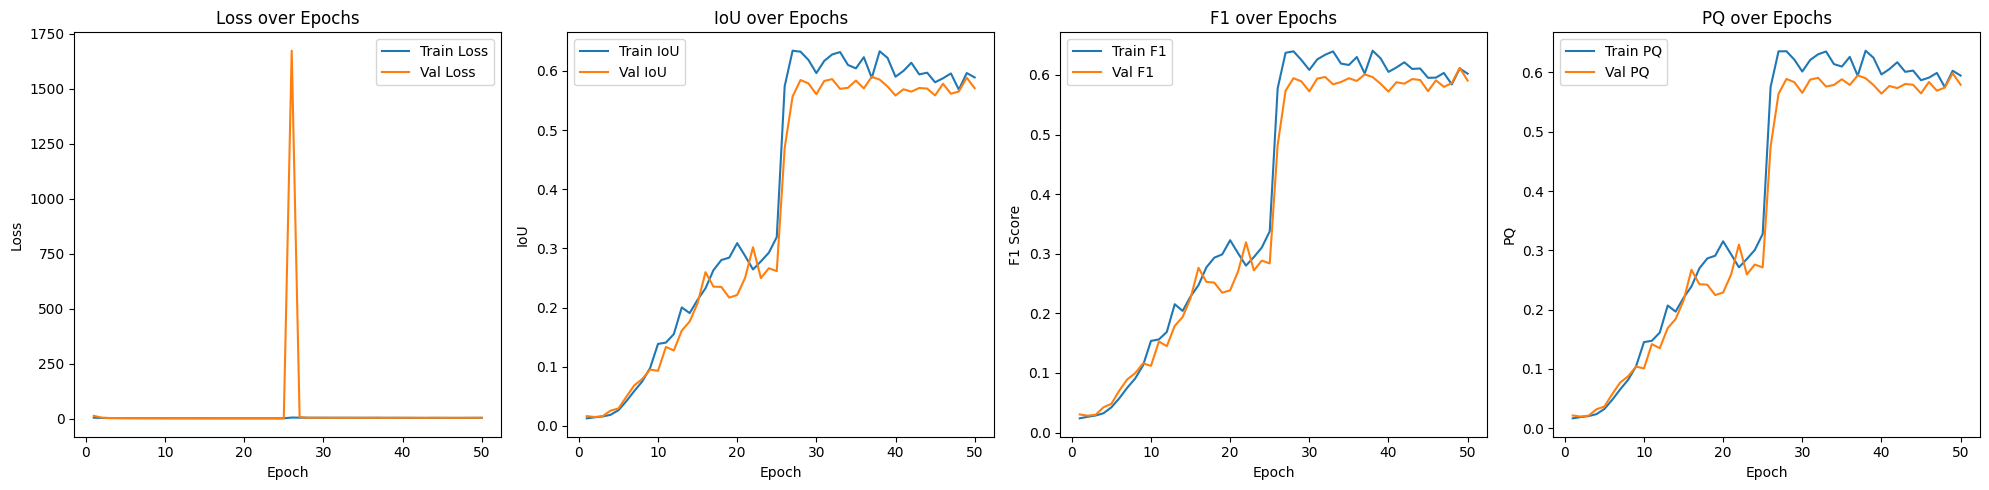

Saved training metrics to training_metrics.csv


In [24]:
train(model, criterion, train_dataloader, val_dataloader, device, 
      num_classes=NUM_CLASSES, epochs=25, patience=25)

In [25]:
final_evaluate(model, test_dataloader, criterion, device, "pretrain", num_classes=NUM_CLASSES)

Validation: 100%|██████████| 8/8 [00:05<00:00,  1.50it/s, f1=0.498, f1_per_class=[0.0447, 0.0358, 0.125, 0.0746, 0.0447, 0.0804, 0.0625], iou=0.484, loss=0.95, pq=0.49]   


Final Test | Loss: 0.9505 | IoU: 0.4838 | F1: 0.4983 | PQ: 0.4901
F1 per class (excluding background): [0.9274400472640991, 0.6233113408088684, 0.3148142695426941, 0.859375, 0.31067079305648804, 0.22952261567115784, 0.5647398829460144, 0.5859375]


In [26]:
final_evaluate(model, test_dataloader, criterion, device, "finetune", num_classes=NUM_CLASSES)

Validation: 100%|██████████| 8/8 [00:06<00:00,  1.19it/s, f1=0.608, f1_per_class=[0.0446, 0.0171, 0.125, 0.0711, 0.0446, 0.1161, 0.125], iou=0.585, loss=3.87, pq=0.595] 


Final Test | Loss: 3.8746 | IoU: 0.5853 | F1: 0.6075 | PQ: 0.5949
F1 per class (excluding background): [0.9292126297950745, 0.6774553656578064, 0.38225141167640686, 0.859375, 0.3056313395500183, 0.3258928656578064, 0.7879464030265808, 0.9140625]


In [27]:
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_validation_samples(model, dataloader, device, num_classes=6, num_samples=10):
    model.eval()
    samples_shown = 0

    for image, mask, h_grads, v_grads in dataloader:
        image = image.to(device, non_blocking=True)
        mask = mask.to(device, non_blocking=True).long()
        h_grads = h_grads.to(device, non_blocking=True)
        v_grads = v_grads.to(device, non_blocking=True)
        

        np_logits, hv_logits, nc_logits, _, _ = model(image)
        np_pred = torch.argmax(np_logits, dim=1)
        nc_pred = torch.argmax(nc_logits, dim=1)

        postprocessed_pred = postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device)
        
        B = image.size(0)
        for i in range(B):
            if samples_shown >= num_samples:
                return

            fig, axes = plt.subplots(1, 7, figsize=(21, 4))

            # Input image
            axes[0].imshow(image[i].permute(1, 2, 0).cpu().numpy())
            axes[0].set_title("Input Image")
            axes[0].axis('off')

            # Ground truth mask
            axes[1].imshow(mask[i].cpu().numpy(), cmap="jet")
            axes[1].set_title("Ground Truth")
            axes[1].axis('off')

            # Predicted mask
            axes[2].imshow(nc_pred[i].cpu().numpy(), cmap="jet")
            axes[2].set_title("Prediction")
            axes[2].axis('off')

            # Horizontal gradient
            axes[3].imshow(hv_logits[i, 0:1,:,:].cpu().squeeze().numpy(), cmap='viridis')
            axes[3].set_title("HoVer Horizontal")
            axes[3].axis('off')

            # Vertical gradient
            axes[4].imshow(hv_logits[i, 1:2,:,:].cpu().squeeze().numpy(), cmap='viridis')
            axes[4].set_title("HoVer Vertical")
            axes[4].axis('off')

            axes[5].imshow(np_pred[i].cpu().squeeze().numpy(), cmap='gray')
            axes[5].set_title("Binary Segmentation")
            axes[5].axis('off')

            axes[6].imshow(postprocessed_pred[i].cpu().squeeze().numpy(), cmap="jet")
            axes[6].set_title("Post Processed")
            axes[6].axis('off')

            plt.tight_layout()
            plt.show()

            samples_shown += 1

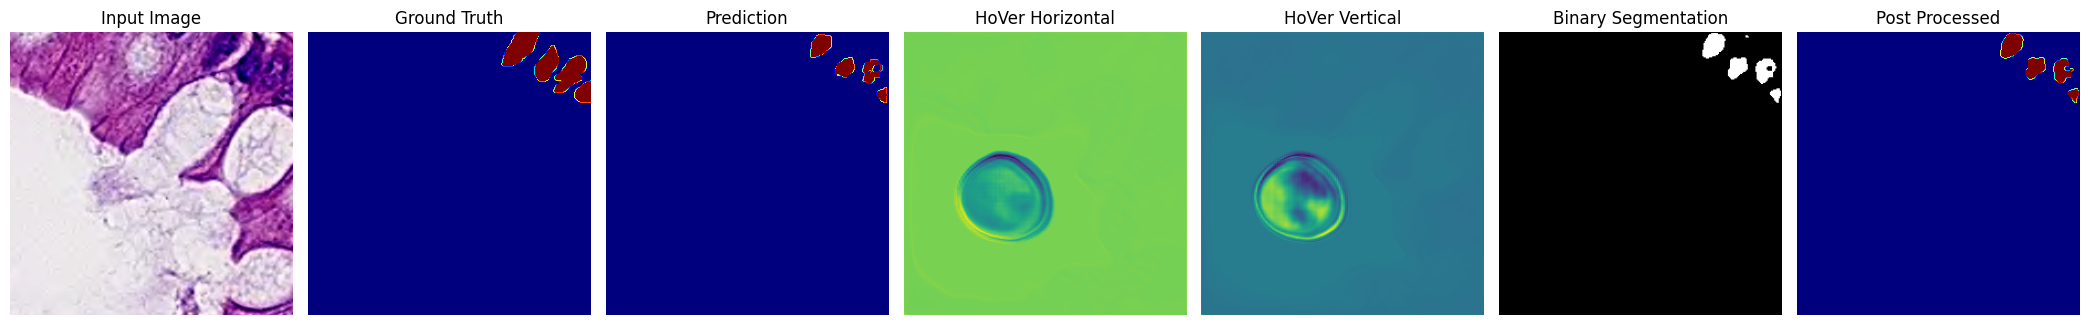

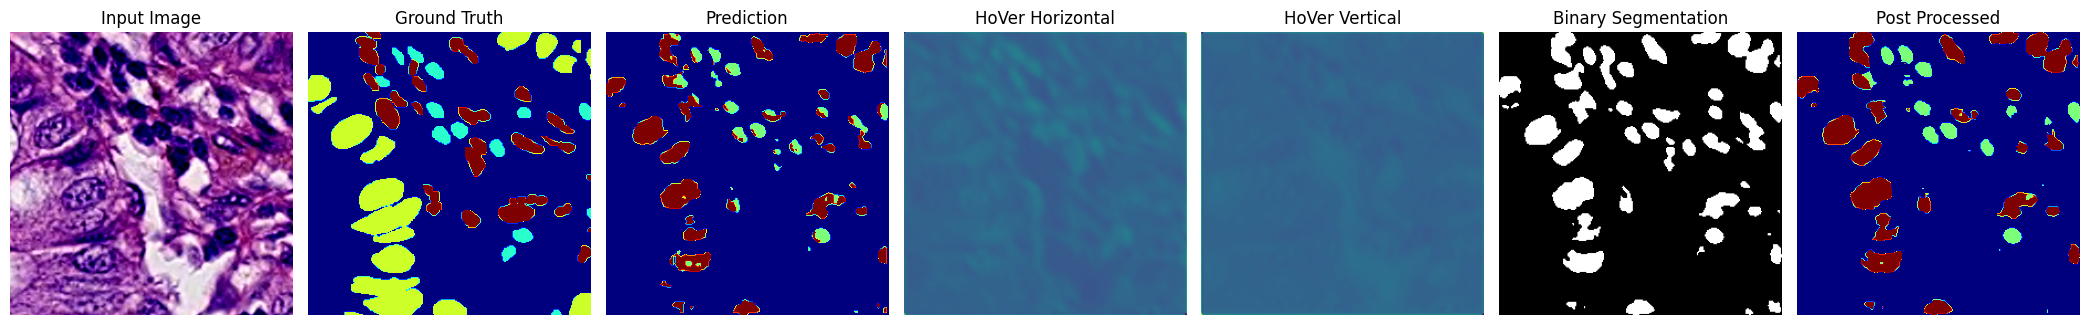

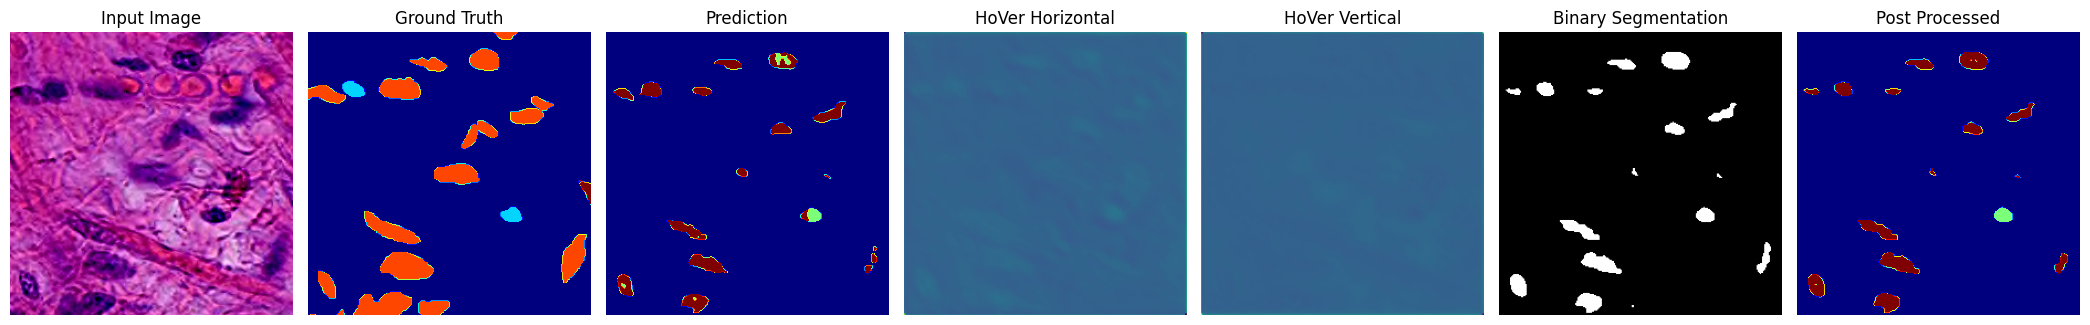

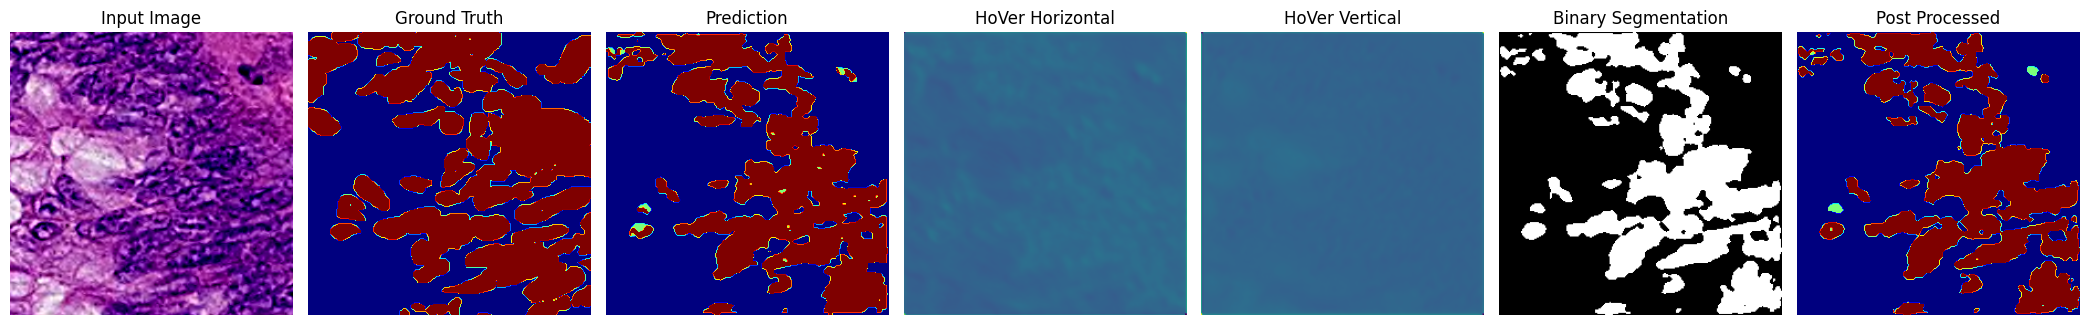

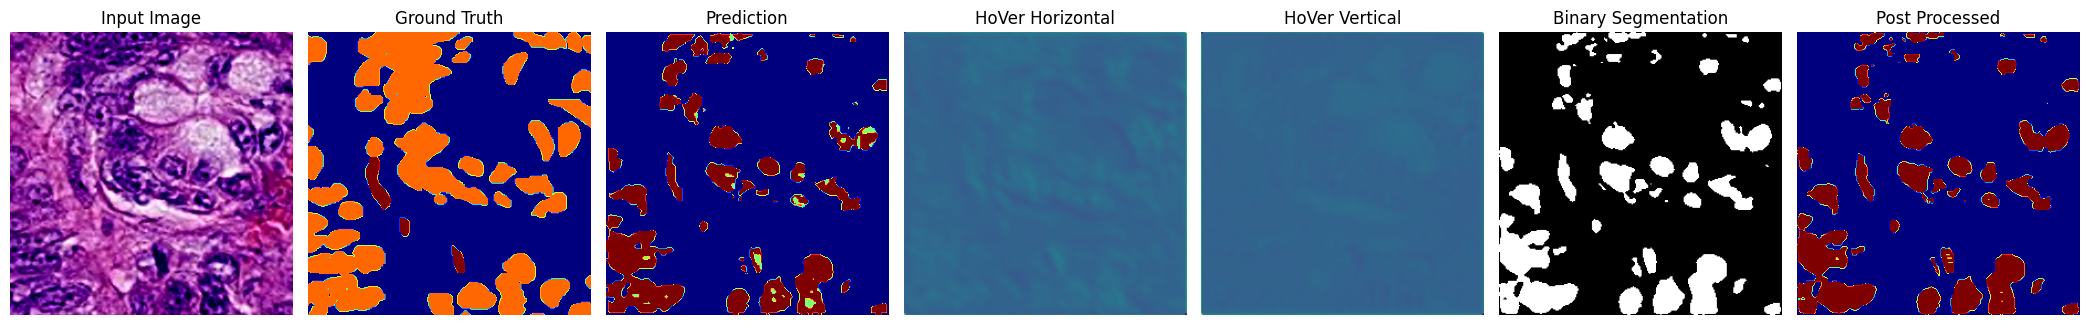

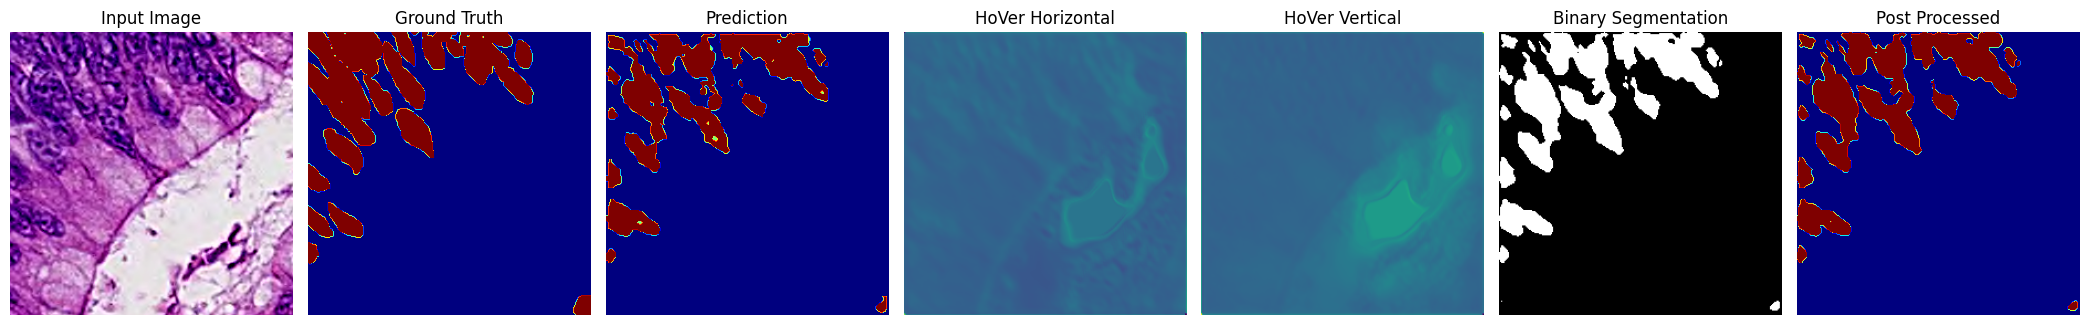

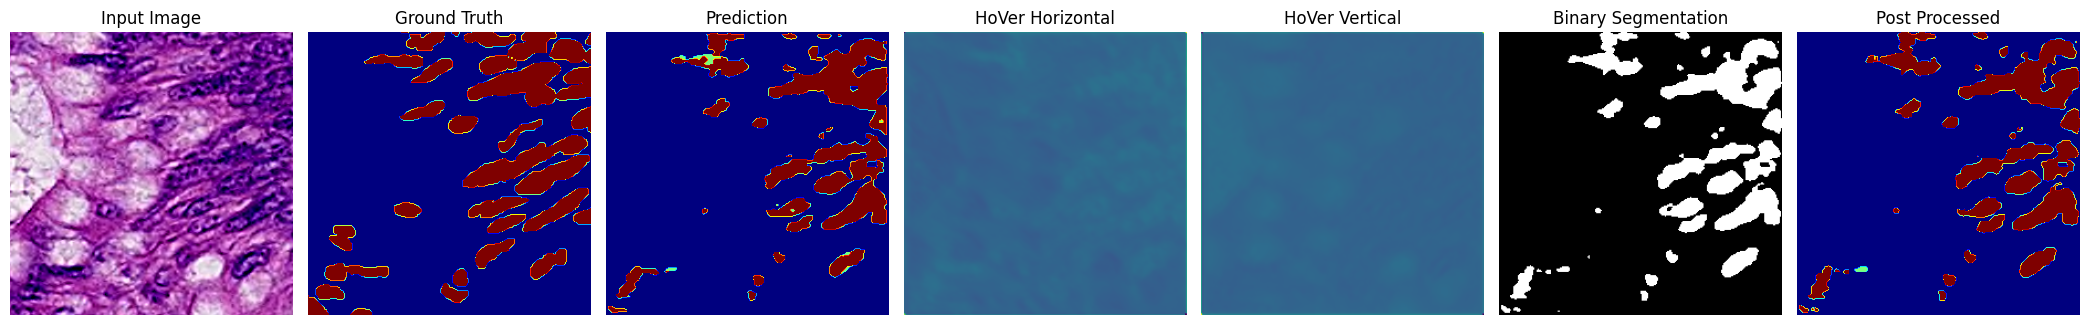

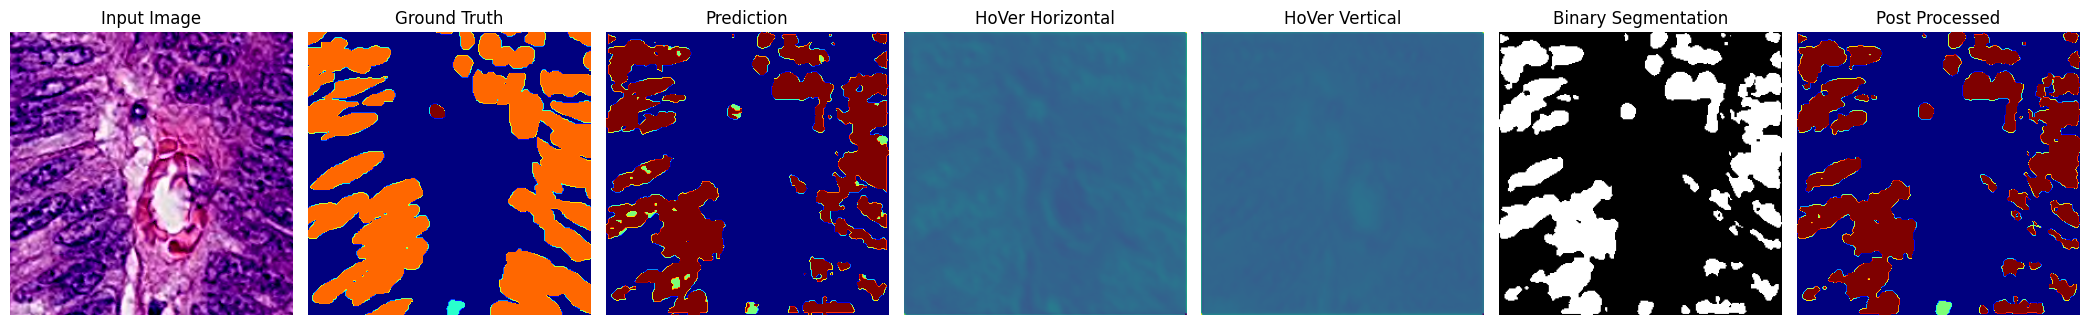

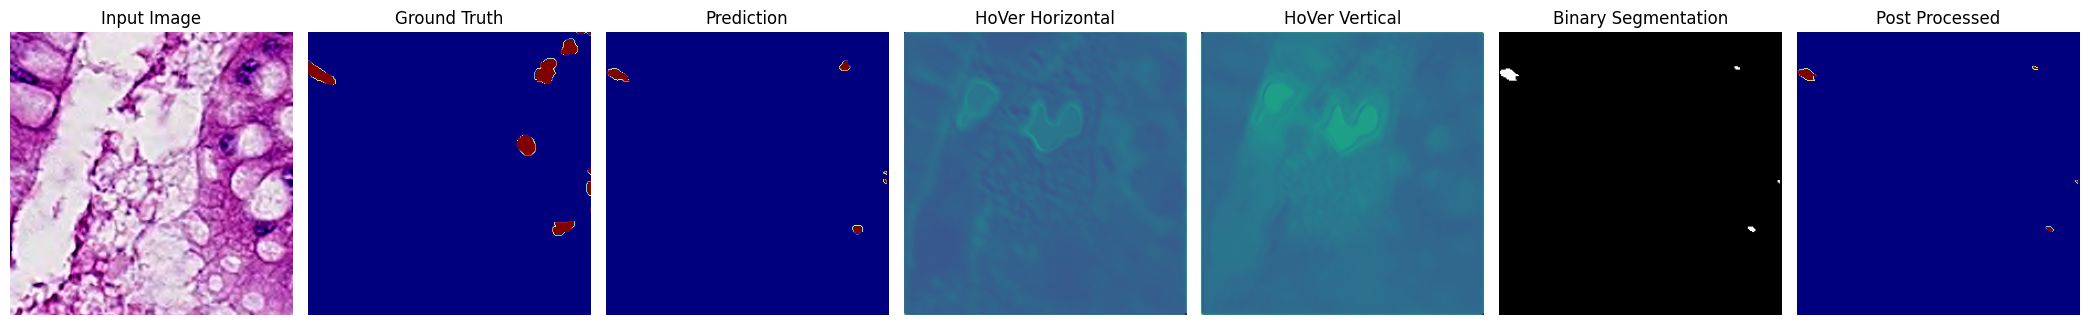

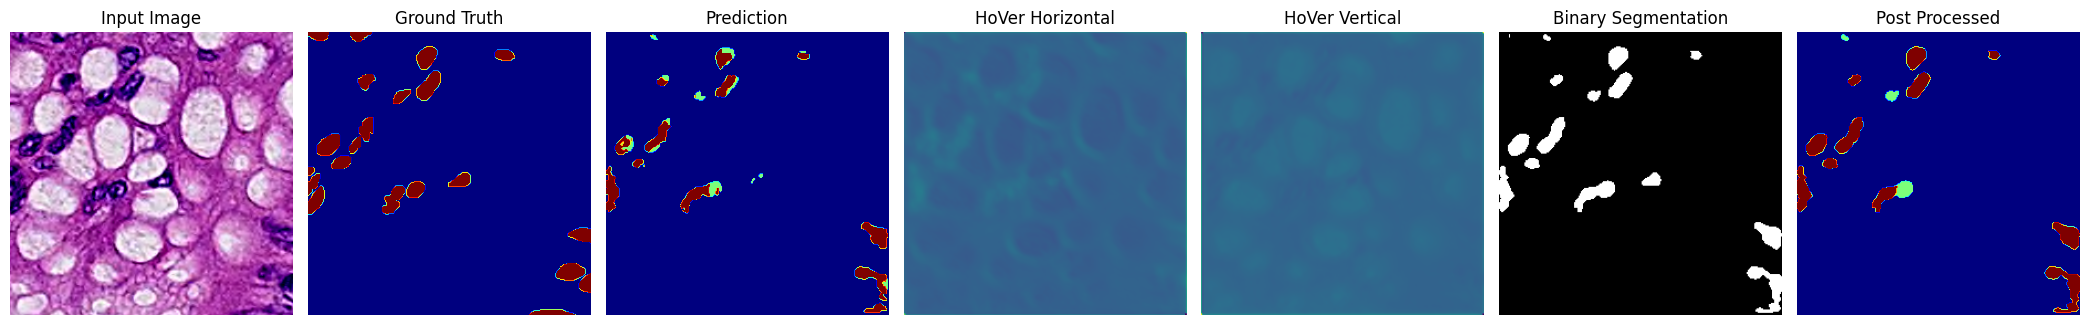

In [28]:
plot_validation_samples(model, test_dataloader, device, num_classes=NUM_CLASSES, num_samples=10)